SC_SP 延遲之策略設計

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import islice
from datetime import datetime, timedelta
import re
import os
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import MultipleLocator
from matplotlib.ticker import FuncFormatter
import matplotlib.gridspec as gridspec
from matplotlib.font_manager import FontProperties as font
import matplotlib
matplotlib.rc('font', family='Microsoft JhengHei') # 在圖表上顯示中文
import matplotlib.ticker as mtick
from collections import Counter

In [139]:
def load_data(pcp_path1, pcp_path2):
    """ 讀取PCP資料+每日日內tick資料 """
    df_pcp1 = pd.read_csv(pcp_path1, encoding='utf-8', low_memory = False)
    df_pcp2 = pd.read_csv(pcp_path2, encoding='utf-8', low_memory = False)

    # 合併兩個 DataFrame
    df_pcp = pd.concat([df_pcp1, df_pcp2], ignore_index=True)

    return df_pcp


def commodityid_time(year, target_month):
    """
    自動判斷期貨與選擇權商品代碼，解決跨年 (12 月 & 1 月) 的問題
    """
    month_code = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L"]
    put_code = ["M", "N", "O", "P", "Q", "R", "S", "T", "U", "V", "W", "X"]
    
    # 取得年份的最後一位數 (e.g., 2024 -> "4")
    year_short = str(year)[-1]

    # 計算目標到期月份的索引
    target_month_idx = target_month - 1  # 索引從 0 開始
    
    # 生成商品代碼
    call_codes = [f"{month_code[target_month_idx]}{year_short}"]
    put_codes = [f"{put_code[target_month_idx]}{year_short}"]
    code =  'MXF' + month_code[target_month_idx] + year_short

    return call_codes, put_codes, code

def preprocess_pcp(df_pcp, call_codes, put_codes):
    """
    1. 轉換 TradeTime 格式
    2. 區分 Call、Put、期貨
    3. 紀錄 BS (買賣方向)
    """
    
    df_pcp = df_pcp.copy() # 創建副本，不影響原本數據
    df_pcp['TradeTime'] = pd.to_datetime(df_pcp['TradeTime']) # 確保時間為 datetime64
    df_pcp['CommodityId'] = df_pcp['CommodityId'].astype(str) # 確保代碼為 string

    # 辨別call, put, fut以及分群，CALL與PUT主要以商品後兩碼去識別，FUT則是鎖定MXF去識別
    df_call = df_pcp[(df_pcp['CommodityId'].str[-2:].isin(call_codes)) & (~df_pcp['CommodityId'].str.startswith('MXF'))].copy() # Call的部分因為商品後兩碼與期貨相同，所以最後需去除期貨數據
    df_put = df_pcp[df_pcp['CommodityId'].str[-2:].isin(put_codes)].copy()
    df_fut = df_pcp[df_pcp['CommodityId'].str.startswith('MXF')].copy()
    
    return df_call, df_put, df_fut


def get_strike_price(option_id):
    """
    從選擇權代碼提取履約價，ex:TXO23000j4中取出23000
    """
    try:
        return int(option_id[3:8])
    except ValueError:
        return None
    

def construct_pcp(df_call, df_put, df_fut):
    """
    透過時間序列找出最近的 Call、Put、期貨 (MXF) 組成 PCP，並解決數據偏差與重複抓取問題
    """

    # 將Call, Put, Fut按照TradeTime排序(由小到大)
    df_call = df_call.sort_values(by="TradeTime").copy()
    df_put = df_put.sort_values(by="TradeTime").copy()
    df_fut = df_fut.sort_values(by="TradeTime").copy()
    
    pcp_list = []  # 儲存 PCP 組合
    
    # 以Call為基準去抓履約價，並去Mapping Put, Fut 的資料，組成PCP
    for _, call_row in df_call.iterrows(): # 忽略index值
        call_time = call_row['TradeTime'] 
        call_price = call_row['Price']
        call_id = call_row['CommodityId']
        call_fee = call_row['Fee']
        call_bs = call_row['BS']
        strike_price = get_strike_price(call_id)
        
        if strike_price is None:
            continue

        # 確保 Call、Put 履約價相同，如果Put對不上Call，則移除此筆資料
        put_candidates = df_put[df_put['CommodityId'].apply(get_strike_price) == strike_price]
        put_candidates = put_candidates.dropna(subset=['TradeTime'])
        put_candidates['TradeTime'] = pd.to_datetime(put_candidates['TradeTime'])

        # 找最接近的 Put，設定與Call時間差需 <= 5分鐘
        put_row = put_candidates.iloc[(put_candidates['TradeTime'] - call_time).abs().argsort()[:1]] # 計算每個TradeTime Put與Call差距，並找尋時間差最小的存入put_row
        if put_row.empty or abs(put_row['TradeTime'].values[0] - call_time) > timedelta(minutes=5): # 如果找不到or時間差大於5分鐘即忽略
            continue


        put_time = put_row['TradeTime'].values[0] # 透過values[0]轉換 Pandas Series to NumPy (每個Pandas Series 也僅有唯一值)
        put_price = put_row['Price'].values[0]
        put_id = put_row['CommodityId'].values[0]
        put_fee = put_row['Fee'].values[0]
        put_bs = put_row['BS'].values[0]
        
        # 找最接近的 Future，設定與Call時間差需 <= 5分鐘
        fut_row = df_fut.iloc[(df_fut['TradeTime'] - call_time).abs().argsort()[:1]]
        if fut_row.empty or abs(fut_row['TradeTime'].values[0] - call_time) > timedelta(minutes=5):
            continue
        
        fut_time = fut_row['TradeTime'].values[0]
        fut_price = fut_row['Price'].values[0]
        fut_id = fut_row['CommodityId'].values[0]
        fut_fee = fut_row['Fee'].values[0]
        fut_bs = fut_row['BS'].values[0]
        
        # 計算交易成本與手續費
        total_fee = call_fee + put_fee + fut_fee 

        # 統整成 PCP 資訊一覽 List
        pcp = {
            "TradeTime": call_time,
            "StrikePrice":strike_price,
            "FuturePrice": fut_price,
            "FutureID": fut_id,
            "FutureBS": fut_bs,
            "FutureFee": fut_fee,
            "CallPrice": call_price,
            "CallID": call_id,
            "CallBS": call_bs,
            "CallFee": call_fee,
            "PutPrice": put_price,
            "PutID": put_id,
            "PutBS": put_bs,
            "PutFee": put_fee,
            "Fee": total_fee,
            "CallTime": call_time,
            "PutTime": put_time,
            "FutTime": fut_time
        }
        pcp_list.append(pcp)

    df_pcp_final = pd.DataFrame(pcp_list)
    return df_pcp_final

def calculate_fees(df):
    """ 
    自行計算費用與稅
    1. 稅：
    小台 0.00002*50
    選擇權 0.001*50
    2. 手續費：
    小台一口13.3元
    選擇權一口10.8元
    買賣都要稅&費

    由於數據陳列時就是將每筆數據都獨立開來，因此可能會小幅低估/高估總花費
    """
    df["FutureTax"] = round(df["FuturePrice"] * 0.00002 * 50,0)
    df["FutureFee"] = round(13.3,0)

    df["CallTax"] = round(df["CallPrice"] * 0.001 * 50,0)
    df["CallFee"] = round(10.8,0) 

    df["PutTax"] = round(df["PutPrice"] * 0.001 * 50,0)
    df["PutFee"] = round(10.8,0)  # 買賣皆需手續費

    # 計算總交易費用 
    df["NewFee"] = df["FutureTax"] + df["FutureFee"] + df["CallTax"] + df["CallFee"] + df["PutTax"] + df["PutFee"]

    return df


def convert_time_format(df):
    """ 
    轉換時間格式，將 TradeTime 分拆為 Date 和 Time 
    """
    trade_d = []
    trade_t = []
    
    for t in df['TradeTime']:
        dt = datetime.strptime(str(t), "%Y-%m-%d %H:%M:%S")  # 確保 TradeTime 格式正確解析
        trade_d.append(dt.strftime("%Y%m%d"))  # 提取日期，格式 YYYYMMDD
        trade_t.append(dt.strftime("%H%M%S"))  # 提取時間，格式 HHMMSS
    
    df['Date'] = trade_d  # 新增 Date 欄位
    df['Time'] = trade_t  # 新增 Time 欄位
    
    return df


def split_datetime_column_and_clean(df, column_name):
    """ 
    將指定以 Time 結尾的欄位分拆為客製化的 Time 欄位
    """
    if column_name not in df.columns:
        raise ValueError(f"欄位 '{column_name}' 不存在於 DataFrame 中")

    # 去除 'Time' 後綴作為基底名稱
    base_column_name = column_name[:-4]  # 移除 'Time'

    # 自訂生成的欄位名稱
    time_column_name = f"{base_column_name}_Time"

    # 用於存放分拆結果的列表
    time_list = []

    for t in df[column_name]:
        # 確保欄位值被正確解析為 datetime 格式
        dt = datetime.strptime(str(t), "%Y-%m-%d %H:%M:%S")
        time_list.append(dt.strftime("%H%M%S"))  # 提取時間，格式 HHMMSS

    # 新增客製化的 Time 欄位
    df[time_column_name] = time_list
    
    return df

def df_origin_pcp_mapping(pcp_path1, pcp_path2, year, month, start_time, end_time):
    """
    讀取 PCP 資料，過濾指定月份數據，並依照設定時間範圍 (`start_time` ~ `end_time`) 篩選資料
    """
    df_pcp = load_data(pcp_path1, pcp_path2)
    call_codes, put_codes, code = commodityid_time(year, month)
    df_call, df_put, df_fut = preprocess_pcp(df_pcp, call_codes, put_codes)
    df_final_pcp = construct_pcp(df_call, df_put, df_fut)
    df_final_pcp = convert_time_format(df_final_pcp)
    df_final_pcp = split_datetime_column_and_clean(df_final_pcp, 'CallTime')
    df_final_pcp = split_datetime_column_and_clean(df_final_pcp, 'PutTime')
    df_final_pcp = split_datetime_column_and_clean(df_final_pcp, 'FutTime')
    df_final_pcp = calculate_fees(df_final_pcp)
    
    # 過濾期貨代碼
    df_final_pcp = df_final_pcp[df_final_pcp['FutureID'] == code]

    # **新增時間範圍過濾**
    df_final_pcp = df_final_pcp[
        (df_final_pcp['Time'].astype(int) >= start_time) & 
        (df_final_pcp['Time'].astype(int) <= end_time)
    ]

    return df_final_pcp


In [196]:
def load_tick_data(tick_folder, files):
    """ 讀取PCP資料+每日日內tick資料 """
    df_list = [pd.read_csv(f"{tick_folder}/2025_{f[:-4]}.csv", encoding='cp950', low_memory=False) for f in files]
    combined_df = pd.concat(df_list, ignore_index=True)  # 合併多個 DataFrame
    
    # 篩選出目標月份的資料，同時排除 IV = 9999的數據
    filtered_df = combined_df[combined_df['IV'] != 9999]
    
    return filtered_df

def filter_by_month(df, year, target_month):
    """
    根據指定年份與月份篩選資料，只保留該月資料
    """
    df['成交日期'] = pd.to_datetime(df['成交日期'], format='%Y%m%d')

    # 建立當月的起始與結束日期 (如: 10月 → 9/1 ~ 11/1)
    if target_month == 1:
        start_date = pd.Timestamp(year=year - 1, month=12, day=1)
    else:
        start_date = pd.Timestamp(year=year, month=target_month - 1, day=1)

    if target_month == 12:
        end_date = pd.Timestamp(year=year + 1, month=1, day=1)
    else:
        end_date = pd.Timestamp(year=year, month=target_month + 1, day=1)

    # 篩選該月份的資料
    filtered_df = df[(df['成交日期'] >= start_date) & (df['成交日期'] <= end_date)]
    return filtered_df

def convert_buy_sell(df):
    """
    將買賣權別欄位轉換為 'C' (買權) 或 'P' (賣權)
    """
    df = df.copy()
    df['買賣權別'] = df['買賣權別'].replace({1: 'C', 0: 'P'})
    return df

def option_tick_data(tick_folder, files, year, month, start_time, end_time):
    """
    讀取 Tick 數據，並根據:
    - 指定月份
    - 指定時間範圍 (start_time 到 end_time)
    進行過濾
    """
    df = load_tick_data(tick_folder, files)
    filtered_df = filter_by_month(df, year, month)
    df_tick = convert_buy_sell(filtered_df)

    # 轉換日期格式，篩選特定到期月份
    date = f"{year}{month:02d}"
    df_tick = df_tick[df_tick["到期月份(週別)"] == date]

    # **加入時間篩選**
    df_tick = df_tick[(df_tick['成交時間'] >= start_time) & (df_tick['成交時間'] <= end_time)]

    return df_tick

給1月的

In [157]:
def load_tick_data(tick_folder1, tick_folder2, files1, files2):
    """ 讀取PCP資料+每日日內tick資料 """
    df_list_1 = [pd.read_csv(f"{tick_folder1}/2024_{f[:-4]}.csv", encoding='cp950', low_memory=False) for f in files1]
    df_list_2 = [pd.read_csv(f"{tick_folder2}/2025_{f[:-4]}.csv", encoding='cp950', low_memory=False) for f in files2]
    combined_df = pd.concat(df_list_1 + df_list_2, ignore_index=True)  # 合併多個 DataFrame
    
    # 篩選出目標月份的資料，同時排除 IV = 9999的數據
    filtered_df = combined_df[combined_df['IV'] != 9999]
    
    return filtered_df

def filter_by_month(df, year, target_month):
    """
    根據指定年份與月份篩選資料，只保留該月資料
    """
    df['成交日期'] = pd.to_datetime(df['成交日期'], format='%Y%m%d')

    # 建立當月的起始與結束日期 (如: 10月 → 9/1 ~ 11/1)
    if target_month == 1:
        start_date = pd.Timestamp(year=year - 1, month=12, day=1)
    else:
        start_date = pd.Timestamp(year=year, month=target_month - 1, day=1)

    if target_month == 12:
        end_date = pd.Timestamp(year=year + 1, month=1, day=1)
    else:
        end_date = pd.Timestamp(year=year, month=target_month + 1, day=1)

    # 篩選該月份的資料
    filtered_df = df[(df['成交日期'] >= start_date) & (df['成交日期'] <= end_date)]
    return filtered_df

def convert_buy_sell(df):
    """
    將買賣權別欄位轉換為 'C' (買權) 或 'P' (賣權)
    """
    df = df.copy()
    df['買賣權別'] = df['買賣權別'].replace({1: 'C', 0: 'P'})
    return df

def option_tick_data(tick_folder1, tick_folder2, files1, files2, year, month, start_time, end_time):
    """
    讀取 Tick 數據，並根據:
    - 指定月份
    - 指定時間範圍 (start_time 到 end_time)
    進行過濾
    """
    df = load_tick_data(tick_folder1, tick_folder2, files1, files2)
    filtered_df = filter_by_month(df, year, month)
    df_tick = convert_buy_sell(filtered_df)

    # 轉換日期格式，篩選特定到期月份
    date = f"{year}{month:02d}"
    df_tick = df_tick[df_tick["到期月份(週別)"] == date]

    # **加入時間篩選**
    df_tick = df_tick[(df_tick['成交時間'] >= start_time) & (df_tick['成交時間'] <= end_time)]

    return df_tick

### 輸入之不同月份

In [677]:
# 1月到期
pcp_path = r'C:/Users/ptdintern1.fut/Desktop/new_code/Jan pcp.csv'
tick_folder = r'D:/Greek/2024'
files = ['01_02.csv', '01_03.csv','01_04.csv', '01_05.csv', '01_08.csv',
         '01_09.csv', '01_10.csv','01_11.csv', '01_12.csv', '01_15.csv',
         '01_16.csv', '01_17.csv','01_18.csv' ,'01_19.csv' ,'01_22.csv',
         '01_23.csv','01_24.csv','01_25.csv','01_26.csv','01_29.csv',
         '01_30.csv','01_31.csv']

year = 2024
month = 1

start_time1 = 30000  # 設定起始時間 (3:00)
end_time1 = 50000  # 設定結束時間 (5:00)

start_time2 = 84500  # 設定起始時間
end_time2 = 90000  # 設定結束時間

settlement_price=17167

df_pcp = df_origin_pcp_mapping(pcp_path, year, month, start_time1, end_time1)
df_tick = option_tick_data(tick_folder, files, year, month, start_time2, end_time2)

KeyboardInterrupt: 

In [135]:
# 2月到期
pcp_path1 = r'C:/Users/ptdintern1.fut/Desktop/new_code/Jan pcp.csv'
pcp_path2 = r'C:/Users/ptdintern1.fut/Desktop/new_code/Feb pcp.csv'
tick_folder = r'D:/Greek/2024'
files1 = ['01_02.csv', '01_03.csv','01_04.csv', '01_05.csv', '01_08.csv',
         '01_09.csv', '01_10.csv','01_11.csv', '01_12.csv', '01_15.csv',
         '01_16.csv', '01_17.csv','01_18.csv' ,'01_19.csv' ,'01_22.csv',
         '01_23.csv','01_24.csv','01_25.csv','01_26.csv','01_29.csv',
         '01_30.csv','01_31.csv']

files2 = ['02_01.csv', '02_02.csv','02_05.csv', '02_15.csv', '02_16.csv',
         '02_19.csv', '02_20.csv','02_21.csv', '02_22.csv', '02_23.csv',
         '02_26.csv', '02_27.csv','02_29.csv']

files = files1 + files2

year = 2024
month = 2

start_time1 = 30000  # 設定起始時間 (3:00)
end_time1 = 50000  # 設定結束時間 (5:00)

start_time2 = 84500  # 設定起始時間
end_time2 = 90000  # 設定結束時間

settlement_price=18670

df_pcp = df_origin_pcp_mapping(pcp_path1, pcp_path2, year, month, start_time1, end_time1)
df_tick = option_tick_data(tick_folder, files, year, month, start_time2, end_time2)

In [33]:
# 3月到期
pcp_path1 = r'C:/Users/ptdintern1.fut/Desktop/new_code/Feb pcp.csv'
pcp_path2 = r'C:/Users/ptdintern1.fut/Desktop/new_code/Mar pcp.csv'
tick_folder = r'D:/Greek/2024'
files1 = ['02_01.csv', '02_02.csv','02_05.csv', '02_15.csv', '02_16.csv',
         '02_19.csv', '02_20.csv','02_21.csv', '02_22.csv', '02_23.csv',
         '02_26.csv', '02_27.csv','02_29.csv']

files2 = ['03_01.csv', '03_04.csv','03_05.csv', '03_06.csv', '03_07.csv',
         '03_08.csv', '03_11.csv','03_12.csv', '03_13.csv', '03_14.csv',
         '03_15.csv', '03_18.csv','03_19.csv', '03_20.csv', '03_21.csv', 
         '03_22.csv', '03_25.csv','03_26.csv', '03_27.csv', '03_28.csv',
         '03_29.csv']

files = files1 + files2

year = 2024
month = 3

start_time1 = 30000  # 設定起始時間 (3:00)
end_time1 = 50000  # 設定結束時間 (5:00)

start_time2 = 84500  # 設定起始時間
end_time2 = 90000  # 設定結束時間

settlement_price=19747

df_pcp = df_origin_pcp_mapping(pcp_path1, pcp_path2, year, month, start_time1, end_time1)
df_tick = option_tick_data(tick_folder, files, year, month, start_time2, end_time2)

In [447]:
# 4月到期
pcp_path1 = r'C:/Users/ptdintern1.fut/Desktop/new_code/Mar pcp.csv'
pcp_path2 = r'C:/Users/ptdintern1.fut/Desktop/new_code/Apr pcp.csv'
tick_folder = r'D:/Greek/2024'
files1 = ['03_01.csv', '03_04.csv','03_05.csv', '03_06.csv', '03_07.csv',
         '03_08.csv', '03_11.csv','03_12.csv', '03_13.csv', '03_14.csv',
         '03_15.csv', '03_18.csv','03_19.csv', '03_20.csv', '03_21.csv', 
         '03_22.csv', '03_25.csv','03_26.csv', '03_27.csv', '03_28.csv',
         '03_29.csv']

files2 = ['04_01.csv', '04_02.csv','04_03.csv', '04_08.csv', '04_09.csv',
         '04_10.csv', '04_11.csv','04_12.csv', '04_15.csv', '04_16.csv',
         '04_17.csv', '04_18.csv','04_19.csv', '04_22.csv', '04_23.csv', 
         '04_24.csv', '04_25.csv','04_26.csv', '04_29.csv', '04_30.csv']

files = files1 + files2

year = 2024
month = 4

start_time1 = 30000  # 設定起始時間 (3:00)
end_time1 = 50000  # 設定結束時間 (5:00)

start_time2 = 84500  # 設定起始時間
end_time2 = 90000  # 設定結束時間

settlement_price=20238

df_pcp = df_origin_pcp_mapping(pcp_path1, pcp_path2, year, month, start_time1, end_time1)
df_tick = option_tick_data(tick_folder, files, year, month, start_time2, end_time2)

In [426]:
# 5月到期
pcp_path1 = r'C:/Users/ptdintern1.fut/Desktop/new_code/Apr pcp.csv'
pcp_path2 = r'C:/Users/ptdintern1.fut/Desktop/new_code/May pcp.csv'
tick_folder = r'D:/Greek/2024'
files1 = ['04_01.csv', '04_02.csv','04_03.csv', '04_08.csv', '04_09.csv',
         '04_10.csv', '04_11.csv','04_12.csv', '04_15.csv', '04_16.csv',
         '04_17.csv', '04_18.csv','04_19.csv', '04_22.csv', '04_23.csv', 
         '04_24.csv', '04_25.csv','04_26.csv', '04_29.csv', '04_30.csv']

files2 = ['05_02.csv', '05_03.csv','05_06.csv', '05_07.csv', '05_08.csv',
         '05_09.csv', '05_10.csv','05_13.csv', '05_14.csv', '05_15.csv',
         '05_16.csv', '05_17.csv','05_20.csv', '05_21.csv', '05_22.csv', 
         '05_23.csv', '05_24.csv','05_27.csv', '05_28.csv', '05_29.csv',
         '05_30.csv', '05_31.csv']

files = files1 + files2

year = 2024
month = 5

start_time1 = 30000  # 設定起始時間 (3:00)
end_time1 = 50000  # 設定結束時間 (5:00)

start_time2 = 84500  # 設定起始時間
end_time2 = 90000  # 設定結束時間

settlement_price=21144

df_pcp = df_origin_pcp_mapping(pcp_path1, pcp_path2, year, month, start_time1, end_time1)
df_tick = option_tick_data(tick_folder, files, year, month, start_time2, end_time2)

In [382]:
# 6月到期
pcp_path1 = r'C:/Users/ptdintern1.fut/Desktop/new_code/May pcp.csv'
pcp_path2 = r'C:/Users/ptdintern1.fut/Desktop/new_code/June pcp.csv'
tick_folder = r'D:/Greek/2024'
files1 = ['05_02.csv', '05_03.csv','05_06.csv', '05_07.csv', '05_08.csv',
         '05_09.csv', '05_10.csv','05_13.csv', '05_14.csv', '05_15.csv',
         '05_16.csv', '05_17.csv','05_20.csv', '05_21.csv', '05_22.csv', 
         '05_23.csv', '05_24.csv','05_27.csv', '05_28.csv', '05_29.csv',
         '05_30.csv', '05_31.csv']

files2 = ['06_03.csv', '06_04.csv','06_05.csv', '06_06.csv', '06_07.csv',
         '06_11.csv', '06_12.csv','06_13.csv', '06_14.csv',
         '06_17.csv', '06_18.csv','06_19.csv', '06_20.csv', '06_21.csv', 
         '06_24.csv', '06_25.csv','06_26.csv', '06_27.csv', '06_28.csv']

files = files1 + files2

year = 2024
month = 6

start_time1 = 30000  # 設定起始時間 (3:00)
end_time1 = 50000  # 設定結束時間 (5:00)

start_time2 = 84500  # 設定起始時間
end_time2 = 90000  # 設定結束時間

settlement_price=23228

df_pcp = df_origin_pcp_mapping(pcp_path1, pcp_path2, year, month, start_time1, end_time1)
df_tick = option_tick_data(tick_folder, files, year, month, start_time2, end_time2)

In [202]:
# 7月到期
pcp_path1 = r'C:/Users/ptdintern1.fut/Desktop/new_code/June pcp.csv'
pcp_path2 = r'C:/Users/ptdintern1.fut/Desktop/new_code/July pcp.csv'
tick_folder = r'D:/Greek/2024'
files1 = ['06_03.csv', '06_04.csv','06_05.csv', '06_06.csv', '06_07.csv',
         '06_11.csv', '06_12.csv','06_13.csv', '06_14.csv',
         '06_17.csv', '06_18.csv','06_19.csv', '06_20.csv', '06_21.csv', 
         '06_24.csv', '06_25.csv','06_26.csv', '06_27.csv', '06_28.csv']

files2 = ['07_01.csv', '07_02.csv', '07_03.csv', '07_04.csv', '07_05.csv',
         '07_08.csv', '07_09.csv', '07_10.csv', '07_11.csv', '07_12.csv',
         '07_15.csv', '07_16.csv', '07_17.csv', '07_18.csv', '07_19.csv',
         '07_22.csv', '07_23.csv', '07_26.csv', '07_29.csv', '07_30.csv', '07_31.csv']

files = files1 + files2

year = 2024
month = 7

start_time1 = 30000  # 設定起始時間 (3:00)
end_time1 = 50000  # 設定結束時間 (5:00)

start_time2 = 84500  # 設定起始時間
end_time2 = 90000  # 設定結束時間

settlement_price=23680

df_pcp = df_origin_pcp_mapping(pcp_path1, pcp_path2, year, month, start_time1, end_time1)
df_tick = option_tick_data(tick_folder, files, year, month, start_time2, end_time2)

In [186]:
# 8月到期
pcp_path1 = r'C:/Users/ptdintern1.fut/Desktop/new_code/Aug pcp.csv'
pcp_path2 = r'C:/Users/ptdintern1.fut/Desktop/new_code/July pcp.csv'
tick_folder = r'D:/Greek/2024'
files1 = ['07_01.csv', '07_02.csv', '07_03.csv', '07_04.csv', '07_05.csv',
         '07_08.csv', '07_09.csv', '07_10.csv', '07_11.csv', '07_12.csv',
         '07_15.csv', '07_16.csv', '07_17.csv', '07_18.csv', '07_19.csv',
         '07_22.csv', '07_23.csv', '07_26.csv', '07_29.csv', '07_30.csv', '07_31.csv']

files2 = ['08_01.csv', '08_02.csv',
         '08_05.csv', '08_06.csv', '08_07.csv', '08_08.csv', '08_09.csv',
         '08_12.csv', '08_13.csv', '08_14.csv', '08_15.csv', '08_16.csv',
         '08_19.csv', '08_20.csv', '08_21.csv', '08_22.csv', '08_23.csv',
         '08_26.csv', '08_27.csv', '08_28.csv', '08_29.csv', '08_30.csv']

files = files1 + files2

year = 2024
month = 8

start_time1 = 30000  # 設定起始時間 (3:00)
end_time1 = 50000  # 設定結束時間 (5:00)

start_time2 = 84500  # 設定起始時間
end_time2 = 90000  # 設定結束時間

settlement_price=22200

df_pcp = df_origin_pcp_mapping(pcp_path1, pcp_path2, year, month, start_time1, end_time1)
df_tick = option_tick_data(tick_folder, files, year, month, start_time2, end_time2)

In [230]:
# 9月到期
pcp_path1 = r'C:/Users/ptdintern1.fut/Desktop/new_code/Sep pcp.csv'
pcp_path2 = r'C:/Users/ptdintern1.fut/Desktop/new_code/Aug pcp.csv'
tick_folder = r'D:/Greek/2024'
files2 = ['09_02.csv', '09_03.csv', '09_04.csv', '09_05.csv', '09_06.csv',
         '09_09.csv', '09_10.csv', '09_11.csv', '09_12.csv', '09_13.csv',
         '09_16.csv', '09_18.csv', '09_19.csv', '09_20.csv',
         '09_23.csv', '09_24.csv', '09_25.csv', '09_26.csv', '09_27.csv','09_30.csv',
]

files1 = ['08_01.csv', '08_02.csv',
         '08_05.csv', '08_06.csv', '08_07.csv', '08_08.csv', '08_09.csv',
         '08_12.csv', '08_13.csv', '08_14.csv', '08_15.csv', '08_16.csv',
         '08_19.csv', '08_20.csv', '08_21.csv', '08_22.csv', '08_23.csv',
         '08_26.csv', '08_27.csv', '08_28.csv', '08_29.csv', '08_30.csv'
]

files = files1 + files2

year = 2024
month = 9

start_time1 = 30000  # 設定起始時間 (3:00)
end_time1 = 50000  # 設定結束時間 (5:00)

start_time2 = 84500  # 設定起始時間
end_time2 = 90000  # 設定結束時間

settlement_price=21617

df_pcp = df_origin_pcp_mapping(pcp_path1, pcp_path2, year, month, start_time1, end_time1)
df_tick = option_tick_data(tick_folder, files, year, month, start_time2, end_time2)

In [346]:
# 10月到期
pcp_path1 = r'C:/Users/ptdintern1.fut/Desktop/new_code/Oct pcp.csv'
pcp_path2 = r'C:/Users/ptdintern1.fut/Desktop/new_code/Sep pcp.csv'
tick_folder = r'D:/Greek/2024'
files1 = ['09_02.csv', '09_03.csv', '09_04.csv', '09_05.csv', '09_06.csv',
         '09_09.csv', '09_10.csv', '09_11.csv', '09_12.csv', '09_13.csv',
         '09_16.csv', '09_18.csv', '09_19.csv', '09_20.csv',
         '09_23.csv', '09_24.csv', '09_25.csv', '09_26.csv', '09_27.csv','09_30.csv',
]

files2 = ['10_01.csv', '10_04.csv',
         '10_07.csv', '10_08.csv', '10_09.csv', '10_11.csv',
         '10_14.csv', '10_15.csv', '10_16.csv', '10_17.csv', '10_18.csv',
         '10_21.csv', '10_22.csv', '10_23.csv', '10_24.csv', '10_25.csv',
         '10_28.csv', '10_29.csv', '10_30.csv'
]

files = files1 + files2

year = 2024
month = 10
start_time1 = 30000  # 設定起始時間 (3:00)
end_time1 = 50000  # 設定結束時間 (5:00)

start_time2 = 84500  # 設定起始時間
end_time2 = 90000  # 設定結束時間

settlement_price=22986

df_pcp = df_origin_pcp_mapping(pcp_path1, pcp_path2, year, month, start_time1, end_time1)
df_tick = option_tick_data(tick_folder, files, year, month, start_time2, end_time2)

In [304]:
# 11月到期
pcp_path1 = r'C:/Users/ptdintern1.fut/Desktop/new_code/Oct pcp.csv'
pcp_path2 = r'C:/Users/ptdintern1.fut/Desktop/new_code/Nov pcp.csv'
tick_folder = r'D:/Greek/2024'
files1 = ['10_01.csv', '10_04.csv',
         '10_07.csv', '10_08.csv', '10_09.csv', '10_11.csv',
         '10_14.csv', '10_15.csv', '10_16.csv', '10_17.csv', '10_18.csv',
         '10_21.csv', '10_22.csv', '10_23.csv', '10_24.csv', '10_25.csv',
         '10_28.csv', '10_29.csv', '10_30.csv'
]

files2 = ['11_01.csv', '11_04.csv', '11_05.csv', '11_06.csv', '11_07.csv',
         '11_08.csv', '11_11.csv', '11_12.csv', '11_13.csv', '11_14.csv',
         '11_15.csv', '11_18.csv', '11_19.csv', '11_20.csv', '11_21.csv',
         '11_22.csv', '11_25.csv', '11_26.csv', '11_27.csv', '11_28.csv',
         '11_29.csv'
]

files = files1 + files2

year = 2024
month = 11
start_time1 = 30000  # 設定起始時間 (3:00)
end_time1 = 50000  # 設定結束時間 (5:00)

start_time2 = 84500  # 設定起始時間
end_time2 = 90000  # 設定結束時間

settlement_price=22686

df_pcp = df_origin_pcp_mapping(pcp_path1, pcp_path2, year, month, start_time1, end_time1)
df_tick = option_tick_data(tick_folder, files, year, month, start_time2, end_time2)

In [141]:
# 12月到期
pcp_path1 = r'C:/Users/ptdintern1.fut/Desktop/new_code/Nov pcp.csv'
pcp_path2 = r'C:/Users/ptdintern1.fut/Desktop/new_code/Dec pcp.csv'
tick_folder = r'D:/Greek/2024'
files1 = ['11_01.csv', '11_04.csv', '11_05.csv', '11_06.csv', '11_07.csv',
         '11_08.csv', '11_11.csv', '11_12.csv', '11_13.csv', '11_14.csv',
         '11_15.csv', '11_18.csv', '11_19.csv', '11_20.csv', '11_21.csv',
         '11_22.csv', '11_25.csv', '11_26.csv', '11_27.csv', '11_28.csv',
         '11_29.csv'
]

files2 = ['12_02.csv', '12_03.csv', '12_04.csv', '12_05.csv', '12_06.csv',
         '12_09.csv', '12_10.csv', '12_11.csv', '12_12.csv', '12_13.csv',
         '12_16.csv', '12_17.csv', '12_18.csv', '12_19.csv', '12_20.csv',
         '12_23.csv', '12_24.csv', '12_25.csv', '12_26.csv', '12_27.csv',
         '12_30.csv', '12_31.csv'
]

files = files1 + files2

year = 2024
month = 12
start_time1 = 30000  # 設定起始時間 (3:00)
end_time1 = 50000  # 設定結束時間 (5:00)

start_time2 = 84500  # 設定起始時間
end_time2 = 90000  # 設定結束時間

settlement_price=23105

df_pcp = df_origin_pcp_mapping(pcp_path1, pcp_path2, year, month, start_time1, end_time1)
df_tick = option_tick_data(tick_folder, files, year, month, start_time2, end_time2)

In [158]:
# 2025年1月到期
pcp_path1 = r'C:/Users/ptdintern1.fut/Desktop/new_code/Dec pcp.csv'
pcp_path2 = r'C:/Users/ptdintern1.fut/Desktop/new_code/Jan pcp 2025.csv'
tick_folder1 = r'D:/Greek/2024'
tick_folder2 = r'D:/Greek/2025'
files1 = ['12_02.csv', '12_03.csv', '12_04.csv', '12_05.csv', '12_06.csv',
         '12_09.csv', '12_10.csv', '12_11.csv', '12_12.csv', '12_13.csv',
         '12_16.csv', '12_17.csv', '12_18.csv', '12_19.csv', '12_20.csv',
         '12_23.csv', '12_24.csv', '12_25.csv', '12_26.csv', '12_27.csv',
         '12_30.csv', '12_31.csv'
]

files2 = ['01_02.csv', '01_03.csv', '01_06.csv', '01_07.csv', '01_08.csv',
         '01_09.csv', '01_10.csv', '01_13.csv', '01_14.csv', '01_15.csv',
         '01_16.csv', '01_17.csv', '01_20.csv', '01_21.csv', '01_22.csv'
]

year = 2025
month = 1
start_time1 = 30000  # 設定起始時間 (3:00)
end_time1 = 50000  # 設定結束時間 (5:00)

start_time2 = 84500  # 設定起始時間
end_time2 = 90000  # 設定結束時間

settlement_price= 22519

df_pcp = df_origin_pcp_mapping(pcp_path1, pcp_path2, year, month, start_time1, end_time1)
df_tick = option_tick_data(tick_folder1, tick_folder2, files1, files2, year, month, start_time2, end_time2)

In [197]:
# 2025年2月到期
pcp_path1 = r'C:/Users/ptdintern1.fut/Desktop/new_code/Jan pcp 2025.csv'
pcp_path2 = r'C:/Users/ptdintern1.fut/Desktop/new_code/Feb pcp 2025.csv'
tick_folder = r'D:/Greek/2025'
files1 = ['01_02.csv', '01_03.csv', '01_06.csv', '01_07.csv', '01_08.csv',
         '01_09.csv', '01_10.csv', '01_13.csv', '01_14.csv', '01_15.csv',
         '01_16.csv', '01_17.csv', '01_20.csv', '01_21.csv', '01_22.csv'
]

files2 = ['02_03.csv', '02_04.csv', '02_05.csv', '02_06.csv', '02_07.csv',
         '02_10.csv', '02_11.csv', '02_12.csv', '02_13.csv', '02_14.csv',
         '02_17.csv', '02_18.csv', '02_19.csv', '02_20.csv', '02_21.csv',
         '02_24.csv', '02_25.csv', '02_26.csv', '02_27.csv',
]

files = files1 + files2

year = 2025
month = 2
start_time1 = 30000  # 設定起始時間 (3:00)
end_time1 = 50000  # 設定結束時間 (5:00)

start_time2 = 84500  # 設定起始時間
end_time2 = 90000  # 設定結束時間

settlement_price= 23608

df_pcp = df_origin_pcp_mapping(pcp_path1, pcp_path2, year, month, start_time1, end_time1)
df_tick = option_tick_data(tick_folder, files, year, month, start_time2, end_time2)

In [221]:
# 2025年3月到期
pcp_path1 = r'C:/Users/ptdintern1.fut/Desktop/new_code/Feb pcp 2025.csv'
pcp_path2 = r'C:/Users/ptdintern1.fut/Desktop/new_code/Mar pcp 2025.csv'
tick_folder = r'D:/Greek/2025'
files1 = ['02_03.csv', '02_04.csv', '02_05.csv', '02_06.csv', '02_07.csv',
         '02_10.csv', '02_11.csv', '02_12.csv', '02_13.csv', '02_14.csv',
         '02_17.csv', '02_18.csv', '02_19.csv', '02_20.csv', '02_21.csv',
         '02_24.csv', '02_25.csv', '02_26.csv', '02_27.csv',
]


files2 = ['03_03.csv', '03_04.csv', '03_05.csv', '03_06.csv', '03_07.csv',
         '03_10.csv', '03_11.csv', '03_12.csv', '03_13.csv', '03_14.csv',
         '03_17.csv', '03_18.csv', '03_19.csv', '03_20.csv', '03_21.csv',
         '03_24.csv', '03_25.csv', '03_26.csv', '03_27.csv', '03_28.csv',
         '03_31.csv'
]

files = files1 + files2

year = 2025
month = 3
start_time1 = 30000  # 設定起始時間 (3:00)
end_time1 = 50000  # 設定結束時間 (5:00)

start_time2 = 84500  # 設定起始時間
end_time2 = 90000  # 設定結束時間

settlement_price= 21964

df_pcp = df_origin_pcp_mapping(pcp_path1, pcp_path2, year, month, start_time1, end_time1)
df_tick = option_tick_data(tick_folder, files, year, month, start_time2, end_time2)

In [290]:
# 2025年4月到期
pcp_path1 = r'C:/Users/ptdintern1.fut/Desktop/new_code/Mar pcp 2025.csv'
pcp_path2 = r'C:/Users/ptdintern1.fut/Desktop/new_code/Apr pcp 2025.csv'
tick_folder = r'D:/Greek/2025'
files1 = ['03_03.csv', '03_04.csv', '03_05.csv', '03_06.csv', '03_07.csv',
         '03_10.csv', '03_11.csv', '03_12.csv', '03_13.csv', '03_14.csv',
         '03_17.csv', '03_18.csv', '03_19.csv', '03_20.csv', '03_21.csv',
         '03_24.csv', '03_25.csv', '03_26.csv', '03_27.csv', '03_28.csv',
         '03_31.csv'
]

files2 = ['04_01.csv', '04_02.csv', '04_07.csv', '04_08.csv', '04_09.csv',
         '04_10.csv', '04_11.csv', '04_14.csv', '04_15.csv', '04_16.csv',
         '04_17.csv', '04_18.csv', '04_21.csv', '04_22.csv', '04_23.csv',
]

files = files1 + files2

year = 2025
month = 4
start_time1 = 30000  # 設定起始時間 (3:00)
end_time1 = 50000  # 設定結束時間 (5:00)

start_time2 = 84500  # 設定起始時間
end_time2 = 90000  # 設定結束時間

settlement_price= 19548 # 4/16

df_pcp = df_origin_pcp_mapping(pcp_path1, pcp_path2, year, month, start_time1, end_time1)
df_tick = option_tick_data(tick_folder, files, year, month, start_time2, end_time2)

In [90]:
# 特殊事件
pcp_path1 = r'C:/Users/ptdintern1.fut/Desktop/new_code/Aug pcp.csv'
pcp_path2 = r'C:/Users/ptdintern1.fut/Desktop/new_code/July pcp.csv'
tick_folder = r'D:/Greek/2024'

files = ['08_05.csv', '08_06.csv', '08_07.csv','08_08.csv', '08_09.csv']

year = 2024
month = 8

start_time1 = 30000  # 設定起始時間 (3:00)
end_time1 = 50000  # 設定結束時間 (5:00)

start_time2 = 84500  # 設定起始時間
end_time2 = 90000  # 設定結束時間

df_pcp = df_origin_pcp_mapping(pcp_path1, year, month, start_time1, end_time1)
df_tick = option_tick_data(tick_folder, files, year, month, start_time2, end_time2)

In [174]:
df_pcp 

,TradeTime,StrikePrice,FuturePrice,FutureID,FutureBS,FutureFee,CallPrice,CallID,CallBS,CallFee,...,FutTime,Date,Time,Call_Time,Put_Time,Fut_Time,FutureTax,CallTax,PutTax,NewFee
699,2025-02-22 03:20:00,24000,23492.0,MXFC5,B,13.0,200.0,TXO24000C5,S,11.0,...,2025-02-22 03:20:00,20250222,032000,032000,032000,032000,23.0,10.0,35.0,103.0
700,2025-02-22 03:20:00,23600,23492.0,MXFC5,B,13.0,360.0,TXO23600C5,S,11.0,...,2025-02-22 03:20:00,20250222,032000,032000,032000,032000,23.0,18.0,23.0,99.0
701,2025-02-22 03:20:00,22800,23492.0,MXFC5,B,13.0,870.0,TXO22800C5,S,11.0,...,2025-02-22 03:20:00,20250222,032000,032000,032000,032000,23.0,44.0,8.0,110.0
702,2025-02-22 03:20:00,23500,23492.0,MXFC5,B,13.0,412.0,TXO23500C5,S,11.0,...,2025-02-22 03:20:00,20250222,032000,032000,032000,032000,23.0,21.0,20.0,99.0
703,2025-02-22 03:20:00,23500,23492.0,MXFC5,B,13.0,412.0,TXO23500C5,S,11.0,...,2025-02-22 03:20:00,20250222,032000,032000,032000,032000,23.0,21.0,20.0,99.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3195,2025-03-18 03:28:00,22050,22408.0,MXFC5,B,13.0,403.0,TXO22050C5,S,11.0,...,2025-03-18 03:28:00,20250318,032800,032800,032800,032800,22.0,20.0,2.0,79.0
3196,2025-03-18 04:23:00,23000,22373.0,MXFC5,S,13.0,1.5,TXO23000C5,B,11.0,...,2025-03-18 04:23:00,20250318,042300,042300,042300,042300,22.0,0.0,32.0,89.0
3197,2025-03-18 04:36:00,22000,22400.0,MXFC5,S,13.0,420.0,TXO22000C5,B,11.0,...,2025-03-18 04:36:00,20250318,043600,043600,043600,043600,22.0,21.0,1.0,79.0
3312,2025-03-19 03:07:00,22550,22177.0,MXFC5,S,13.0,1.9,TXO22550C5,B,11.0,...,2025-03-19 03:07:00,20250319,030700,030700,030700,030700,22.0,0.0,19.0,76.0


In [54]:
df_pcp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 114 entries, 519 to 2144
Data columns (total 27 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   TradeTime    114 non-null    datetime64[ns]
 1   StrikePrice  114 non-null    int64         
 2   FuturePrice  114 non-null    float64       
 3   FutureID     114 non-null    object        
 4   FutureBS     114 non-null    object        
 5   FutureFee    114 non-null    float64       
 6   CallPrice    114 non-null    float64       
 7   CallID       114 non-null    object        
 8   CallBS       114 non-null    object        
 9   CallFee      114 non-null    float64       
 10  PutPrice     114 non-null    float64       
 11  PutID        114 non-null    object        
 12  PutBS        114 non-null    object        
 13  PutFee       114 non-null    float64       
 14  Fee          114 non-null    float64       
 15  CallTime     114 non-null    datetime64[ns]
 16  PutTime   

In [173]:
df_tick

,成交日期,履約價格,到期月份(週別),買賣權別,成交時間,成交價格,成交數量(B or S),剩餘到期時間(秒),當下指數,IV,delta,gamma,vega,theta,rho
39015,2025-02-03,20500.0,202503,P,84500.0,158.0,1.0,3819599.0,22714.110169,0.280099,-0.131066,0.000096,16.817328,-5.469085,3.789931
39016,2025-02-03,24000.0,202503,C,84500.0,230.0,2.0,3819599.0,22714.110169,0.213371,0.249034,0.000188,25.068595,-6.294471,6.558937
39017,2025-02-03,25200.0,202503,C,84500.0,68.0,1.0,3819599.0,22714.110169,0.215689,0.093513,0.000098,13.206344,-3.314391,2.485149
39018,2025-02-03,25000.0,202503,C,84500.0,78.0,1.0,3819599.0,22714.110169,0.210729,0.106827,0.000111,14.554410,-3.574786,2.838579
39019,2025-02-03,24500.0,202503,C,84500.0,135.0,1.0,3819599.0,22714.110169,0.210687,0.166444,0.000150,19.733638,-4.866765,4.406388
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17136803,2025-03-19,22200.0,202503,C,90000.0,72.0,1.0,16199.0,22223.770833,0.295565,0.565281,0.002644,1.982447,-156.825693,0.064160
17136804,2025-03-19,22150.0,202503,C,90000.0,105.0,1.0,16199.0,22223.770833,0.304920,0.686449,0.002308,1.785744,-145.896290,0.077822
17136805,2025-03-19,22350.0,202503,C,90000.0,15.5,2.0,16199.0,22223.770833,0.288040,0.194059,0.001895,1.384621,-106.554350,0.022073
17136806,2025-03-19,22100.0,202503,C,90000.0,143.0,1.0,16199.0,22223.770833,0.312352,0.786300,0.001851,1.466536,-122.944484,0.089026


In [152]:
df_tick.info()

<class 'pandas.core.frame.DataFrame'>
Index: 148050 entries, 39015 to 17136807
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   成交日期          148050 non-null  datetime64[ns]
 1   履約價格          148050 non-null  float64       
 2   到期月份(週別)      148050 non-null  object        
 3   買賣權別          148050 non-null  object        
 4   成交時間          148050 non-null  float64       
 5   成交價格          148050 non-null  float64       
 6   成交數量(B or S)  148050 non-null  float64       
 7   剩餘到期時間(秒)     148050 non-null  float64       
 8   當下指數          148050 non-null  float64       
 9   IV            148050 non-null  float64       
 10  delta         148050 non-null  float64       
 11  gamma         148050 non-null  float64       
 12  vega          148050 non-null  float64       
 13  theta         148050 non-null  float64       
 14  rho           148050 non-null  float64       
dtypes: datetime64[ns

### 加入新欄位ArbitrageStrategy，針對PCP的組成，給予腳3 BC、BP、SC、SP四種策略，並且只保留SC、SP的數據

In [291]:
def analyze_pcp_with_bs(df_pcp):
    """
    進一步分析 PCP 數據，包含理論與實際價格比較以及交易腳判斷。
    """
    df_pcp = df_pcp.copy()
    strategy_type = []
    for _, row in df_pcp.iterrows():
        C = row['CallPrice']    # Call 價格
        P = row['PutPrice']     # Put 價格
        FutureBS = row['FutureBS']  # 買賣方向 (B/S)
        
        # 判斷策略類型
        if FutureBS == "B":
            # 理論大：Buy Future + Short Call + Long Put
            if C > P:
                strategy_type.append("BP") # Short Call 腳1, Long Put 腳3
            else:
                strategy_type.append("SC")   # Short Call 腳3, Long Put 腳1

        else:
            # 實際大：Sell Future + Long Call + Short Put
            if C > P:
                strategy_type.append("SP")   # Long Call 腳1, Short Put 腳3
            else:
                strategy_type.append("BC")   # Long Call 腳3, Short Put 腳1
        
    
    df_pcp["ArbitrageStrategy"] = strategy_type
    
    # 轉成 DataFrame
    df_results = pd.DataFrame(df_pcp)
    return df_results


df_origin_pcp = analyze_pcp_with_bs(df_pcp)

# 排除BC、BP資料，只觀察SC、SP資料
df_origin_pcp = df_origin_pcp[~df_origin_pcp["ArbitrageStrategy"].isin(["BC", "BP"])]


In [99]:
df_origin_pcp

,TradeTime,StrikePrice,FuturePrice,FutureID,FutureBS,FutureFee,CallPrice,CallID,CallBS,CallFee,...,Date,Time,Call_Time,Put_Time,Fut_Time,FutureTax,CallTax,PutTax,NewFee,ArbitrageStrategy
86,2024-11-29 03:56:00,22000,22268.0,MXFL4,S,13.0,373.0,TX122000L4,B,11.0,...,20241129,035600,035600,035600,035600,22.0,19.0,6.0,82.0,SP
138,2024-11-30 03:19:00,23000,22538.0,MXFL4,B,13.0,184.0,TXO23000L4,S,11.0,...,20241130,031900,031900,031900,031900,23.0,9.0,32.0,99.0,SC
211,2024-12-04 03:29:00,22550,23135.0,MXFL4,S,13.0,560.0,TX122550L4,B,11.0,...,20241204,032900,032900,032900,032900,23.0,28.0,0.0,86.0,SP
212,2024-12-04 03:29:00,22300,23135.0,MXFL4,S,13.0,800.0,TX122300L4,B,11.0,...,20241204,032900,032900,032900,032900,23.0,40.0,0.0,98.0,SP
214,2024-12-04 03:47:00,22600,23133.0,MXFL4,S,13.0,700.0,TXO22600L4,B,11.0,...,20241204,034700,034700,034700,034700,23.0,35.0,9.0,102.0,SP
218,2024-12-04 04:58:00,23000,23150.0,MXFL4,S,13.0,150.0,TX123000L4,B,11.0,...,20241204,045800,045800,045800,045800,23.0,8.0,2.0,68.0,SP
294,2024-12-06 04:15:00,22800,23366.0,MXFL4,S,13.0,575.0,TX222800L4,B,11.0,...,20241206,041500,041500,041500,041500,23.0,29.0,2.0,89.0,SP
380,2024-12-10 03:42:00,23500,23261.0,MXFL4,B,13.0,32.0,TX223500L4,S,11.0,...,20241210,034200,034200,034200,034200,23.0,2.0,13.0,73.0,SC
381,2024-12-10 03:42:00,23500,23261.0,MXFL4,B,13.0,32.0,TX223500L4,S,11.0,...,20241210,034200,034200,034200,034200,23.0,2.0,13.0,73.0,SC
382,2024-12-10 03:48:00,24000,23256.0,MXFL4,B,13.0,1.5,TX224000L4,S,11.0,...,20241210,034800,034800,034800,034800,23.0,0.0,36.0,94.0,SC


重新設定索引

In [292]:
def add_numeric_index(df_origin_pcp):
    """
    為 `df_origin_pcp` 新增數字索引 (0, 1, 2, 3...)，但保留原始 PCP 編碼。
    """
    df_origin_pcp1 = df_origin_pcp.reset_index(drop=True)  # **重設索引，使其變為 0, 1, 2, ...**
    df_origin_pcp["PCP_ID"] = df_origin_pcp1.index  # **新增編碼作為 PCP_ID**

    print("Updated df_origin_pcp with numeric index:")
    print(df_origin_pcp.head())  # **顯示前幾筆數據**

    return df_origin_pcp

df_origin_pcp1 = add_numeric_index(df_origin_pcp)

Updated df_origin_pcp with numeric index:
              TradeTime  StrikePrice  FuturePrice FutureID FutureBS  \
88  2025-03-27 03:25:00        22600      21987.0    MXFD5        B   
134 2025-03-28 03:08:00        22600      21834.0    MXFD5        B   
140 2025-03-28 03:51:00        22400      21844.0    MXFD5        B   
141 2025-03-28 03:52:00        22350      21831.0    MXFD5        B   
142 2025-03-28 03:52:00        22350      21831.0    MXFD5        B   

     FutureFee  CallPrice      CallID CallBS  CallFee  ...    Time Call_Time  \
88        13.0       26.0  TX122600D5      S     11.0  ...  032500    032500   
134       13.0        5.7  TX122600D5      S     11.0  ...  030800    030800   
140       13.0       17.5  TX122400D5      S     11.0  ...  035100    035100   
141       13.0       22.0  TX122350D5      S     11.0  ...  035200    035200   
142       13.0       22.0  TX122350D5      S     11.0  ...  035200    035200   

    Put_Time  Fut_Time  FutureTax CallTax PutTax N

### 延遲策略設定

策略1：在開盤後找到相同履約價的 SC / SP，不過是取其開盤5分鐘內的平均價格


策略2：如果找不到相同履約價，可以找原履約價正負100點上下的合約，然後以距離最近的履約價來計算
1. SC可以選比原本履約價大一點的，組成多頭價差
2. SP選比原本履約價小一點的，組成空頭價差

策略3：如果連附近100點都沒有，就直接選擇將腳1、期貨平倉，平倉就是根據tick資料，然後做出相反方向的部位操作

(平均價格依照tick資料來計算，將5分鐘內符合條件之數據相加在除以相加的總數)

目前策略3暫時沒有實施，透過放大tolerance去規避

目前自己在執行類似Put call parity 之策略，主要是區分成腳1、期貨與腳3，在之前的處理上已經合併PCP數據，然後選出時間範圍在3:00~5:00的PCP數據，其中腳3策略為Short call 或是 Short put之策略，設定先不買此腳3，等到隔天早上開盤，在8:45~8:50的時段，選擇三種不同方法去解決

In [302]:
def get_next_trading_date(current_date, df_tick):
    # 排除非交易日，尋找下一個有交易數據的日期
    available_dates = sorted(df_tick["成交日期"].unique())  # 取得所有交易日
    future_dates = [date for date in available_dates if date > current_date]  # 取得晚於當前日期的所有交易日
    
    return future_dates[0] if future_dates else None  # 返回下一個交易日或 None (無可用日期)

考慮有些日期因假日、國定假日、颱風假沒有開盤而順延到下一個開盤日

In [303]:
def find_leg3_and_exit(df_pcp, df_tick, open_time, window, price_tolerance):
    results = []

    # **確保日期格式一致**
    df_pcp = df_pcp.copy()
    df_tick = df_tick.copy()
    df_pcp["Date"] = pd.to_datetime(df_pcp["Date"])
    df_tick["成交日期"] = pd.to_datetime(df_tick["成交日期"])

    for pcp_id, pcp_row in df_pcp.iterrows():
        strike_price = pcp_row["StrikePrice"]
        future_price = pcp_row["FuturePrice"]
        arbitrage_strategy = pcp_row["ArbitrageStrategy"]
        option_type = "C" if arbitrage_strategy == "SC" else "P"

        final_strategy = "Closed Position"
        new_leg3 = None
        new_strike_price = "N/A"
        
        current_date = pcp_row["Date"]

        # **檢查是否為交易日，若不是則順延**
        if current_date not in df_tick["成交日期"].values:
            next_trading_date = get_next_trading_date(current_date, df_tick)
            if next_trading_date is not None:
                current_date = next_trading_date
                print(f"🔄 PCP_ID {pcp_id}: 當天無交易，順延至 {next_trading_date}")
            else:
                print(f"❌ PCP_ID {pcp_id}: 無可用交易日，跳過該筆資料")
                continue

        # **策略 1：精確匹配履約價**
        matching_leg3 = df_tick[
            (df_tick["履約價格"] == strike_price) &
            (df_tick["買賣權別"] == option_type) &
            (df_tick["成交時間"].astype(int) >= open_time) &
            (df_tick["成交時間"].astype(int) <= open_time + window) &
            (df_tick["成交日期"] == current_date)
        ] 

        print(f"PCP_ID {pcp_id}: 找到 {len(matching_leg3)} 筆匹配的 SC/SP 記錄")

        if not matching_leg3.empty:
            new_leg3 = matching_leg3["成交價格"].mean()
            new_strike_price = strike_price
            final_strategy = "Matched Strike Price"
        else:
            # **策略 2：找 ±100 履約價內的 SC / SP**
            nearby_leg3 = df_tick[
                (abs(df_tick["履約價格"] - strike_price) <= price_tolerance) &
                (df_tick["買賣權別"] == option_type)  &
                (df_tick["成交時間"].astype(int) >= open_time) &
                (df_tick["成交時間"].astype(int) <= open_time + window) &
                (df_tick["成交日期"] == current_date)
            ]

            print(f"PCP_ID {pcp_id}: 找到 {len(nearby_leg3)} 筆 ±{price_tolerance} SC/SP 記錄")
            
            # **選擇 SC 履約價更高，SP 履約價更低**
            if not nearby_leg3.empty:
                # **先篩選符合 SC / SP 買賣權別的數據**
                filtered_leg3 = nearby_leg3[nearby_leg3["買賣權別"] == option_type]

                if not filtered_leg3.empty:
                    if arbitrage_strategy == "SC":
                        best_leg3 = filtered_leg3[filtered_leg3["履約價格"] > strike_price] # SC 需要更高的履約價
                    elif arbitrage_strategy == "SP":
                        best_leg3 = filtered_leg3[filtered_leg3["履約價格"] < strike_price] # SP 需要更低的履約價
                    else:
                        best_leg3 = filtered_leg3 # 如果沒有符合條件，則選擇最近的履約價
                    
                    # **如果篩選後仍然是空的，則回退到買賣權別一致但最近的履約價**
                    if best_leg3.empty:
                        best_leg3 = filtered_leg3 # 保證至少符合 `C` 或 `P`
                    
                    # **確保 `best_leg3` 有數據後，再執行 `.iloc[...]`**
                    if not best_leg3.empty:
                        idx = (abs(best_leg3["履約價格"] - strike_price)).idxmin()
                        if idx is not None and idx in best_leg3.index:
                            best_leg3 = best_leg3.loc[idx]
                            new_strike_price = best_leg3["履約價格"]
                            new_leg3 = best_leg3["成交價格"]
                            final_strategy = "Nearby Strike Price"

        # **策略 3：無法匹配時執行平倉**
        if new_leg3 is None:
            closing_prices = df_tick[
                (df_tick["成交時間"].astype(int) >= open_time) &
                (df_tick["成交時間"].astype(int) <= open_time + window) &
                (df_tick["買賣權別"] == option_type) &
                (df_tick["成交日期"] == current_date)
            ]

            if not closing_prices.empty:
                close_price = closing_prices["成交價格"].mean()
                new_leg3 = f"Closed Position at {close_price}"
            else:
                new_leg3 = "Unable to Close Position"

        results.append({
            "PCP_ID": pcp_id,
            "StrikePrice": strike_price,
            "FuturePrice": future_price,
            "ArbitrageStrategy": arbitrage_strategy,
            "NewLeg3Price": new_leg3,
            "FinalStrategy": final_strategy,
            "NewStrikePrice": new_strike_price,
            "TradeDate": current_date  # 記錄實際使用的交易日期
        })

    return pd.DataFrame(results)

# **執行**
open_time = 84500
window = 500
price_tolerance = 200
df_new_leg3 = find_leg3_and_exit(df_origin_pcp, df_tick, open_time, window, price_tolerance)
df_new_leg3 = df_new_leg3.reset_index(drop=True)
df_new_leg3["PCP_ID"] = df_new_leg3.index

PCP_ID 88: 找到 8 筆匹配的 SC/SP 記錄
PCP_ID 134: 找到 18 筆匹配的 SC/SP 記錄
PCP_ID 140: 找到 12 筆匹配的 SC/SP 記錄
PCP_ID 141: 找到 0 筆匹配的 SC/SP 記錄
PCP_ID 141: 找到 71 筆 ±200 SC/SP 記錄
PCP_ID 142: 找到 0 筆匹配的 SC/SP 記錄
PCP_ID 142: 找到 71 筆 ±200 SC/SP 記錄
PCP_ID 143: 找到 37 筆匹配的 SC/SP 記錄
PCP_ID 144: 找到 37 筆匹配的 SC/SP 記錄
🔄 PCP_ID 495: 當天無交易，順延至 2025-03-31 00:00:00
PCP_ID 495: 找到 9 筆匹配的 SC/SP 記錄
🔄 PCP_ID 496: 當天無交易，順延至 2025-03-31 00:00:00
PCP_ID 496: 找到 112 筆匹配的 SC/SP 記錄
🔄 PCP_ID 497: 當天無交易，順延至 2025-03-31 00:00:00
PCP_ID 497: 找到 112 筆匹配的 SC/SP 記錄
🔄 PCP_ID 498: 當天無交易，順延至 2025-03-31 00:00:00
PCP_ID 498: 找到 112 筆匹配的 SC/SP 記錄
🔄 PCP_ID 499: 當天無交易，順延至 2025-03-31 00:00:00
PCP_ID 499: 找到 112 筆匹配的 SC/SP 記錄
🔄 PCP_ID 501: 當天無交易，順延至 2025-03-31 00:00:00
PCP_ID 501: 找到 112 筆匹配的 SC/SP 記錄
🔄 PCP_ID 511: 當天無交易，順延至 2025-03-31 00:00:00
PCP_ID 511: 找到 4 筆匹配的 SC/SP 記錄
🔄 PCP_ID 512: 當天無交易，順延至 2025-03-31 00:00:00
PCP_ID 512: 找到 0 筆匹配的 SC/SP 記錄
PCP_ID 512: 找到 46 筆 ±200 SC/SP 記錄
🔄 PCP_ID 513: 當天無交易，順延至 2025-03-31 00:00:00
PCP_ID 513: 找到 0 筆匹配的 SC

備用，如果真的有出現需要平倉情形在考慮使用

In [67]:
import pandas as pd

def get_next_trading_date(current_date, df_tick):
    """尋找下一個有交易數據的日期"""
    available_dates = sorted(df_tick["成交日期"].unique())
    future_dates = [date for date in available_dates if date > current_date]
    return future_dates[0] if future_dates else None

def find_leg3_and_exit(df_pcp, df_tick, open_time, window, price_tolerance):
    results = []
    closed_positions = []

    # **確保日期格式一致**
    df_pcp = df_pcp.copy()
    df_tick = df_tick.copy()
    df_pcp["Date"] = pd.to_datetime(df_pcp["Date"])
    df_tick["成交日期"] = pd.to_datetime(df_tick["成交日期"])

    for pcp_id, pcp_row in df_pcp.iterrows():
        strike_price = pcp_row["StrikePrice"]
        future_price = pcp_row["FuturePrice"]
        arbitrage_strategy = pcp_row["ArbitrageStrategy"]
        option_type = "C" if arbitrage_strategy == "SC" else "P"
        leg1_price = pcp_row["CallPrice"] if arbitrage_strategy == "SC" else pcp_row["PutPrice"]

        final_strategy = "Closed Position"
        new_leg3 = None
        new_strike_price = "N/A"
        closed_leg1_price = None
        closed_future_price = None

        current_date = pcp_row["Date"]

        # **檢查是否為交易日，若不是則順延**
        if current_date not in df_tick["成交日期"].values:
            next_trading_date = get_next_trading_date(current_date, df_tick)
            if next_trading_date is not None:
                current_date = next_trading_date
                print(f"🔄 PCP_ID {pcp_id}: 當天無交易，順延至 {next_trading_date}")
            else:
                print(f"❌ PCP_ID {pcp_id}: 無可用交易日，跳過該筆資料")
                continue

        # **策略 1：精確匹配履約價**
        matching_leg3 = df_tick[
            (df_tick["履約價格"] == strike_price) &
            (df_tick["買賣權別"] == option_type) &
            (df_tick["成交時間"].astype(int) >= open_time) &
            (df_tick["成交時間"].astype(int) <= open_time + window) &
            (df_tick["成交日期"] == current_date)
        ]

        if not matching_leg3.empty:
            new_leg3 = matching_leg3["成交價格"].mean()
            new_strike_price = strike_price
            final_strategy = "Matched Strike Price"
        else:
            # **策略 2：找 ±100 履約價內的 SC / SP**
            nearby_leg3 = df_tick[
                (abs(df_tick["履約價格"] - strike_price) <= price_tolerance) &
                (df_tick["買賣權別"] == option_type) &
                (df_tick["成交時間"].astype(int) >= open_time) &
                (df_tick["成交時間"].astype(int) <= open_time + window) &
                (df_tick["成交日期"] == current_date)
            ]

            if not nearby_leg3.empty:
                if arbitrage_strategy == "SC":
                    best_leg3 = nearby_leg3[nearby_leg3["履約價格"] > strike_price]  # SC 需要更高履約價
                elif arbitrage_strategy == "SP":
                    best_leg3 = nearby_leg3[nearby_leg3["履約價格"] < strike_price]  # SP 需要更低履約價
                else:
                    best_leg3 = nearby_leg3

                if best_leg3.empty:
                    best_leg3 = nearby_leg3  # 保證至少符合 `C` 或 `P`

                if not best_leg3.empty:
                    idx = (abs(best_leg3["履約價格"] - strike_price)).idxmin()
                    if idx is not None and idx in best_leg3.index:
                        best_leg3 = best_leg3.loc[idx]
                        new_strike_price = best_leg3["履約價格"]
                        new_leg3 = best_leg3["成交價格"]
                        final_strategy = "Nearby Strike Price"

        # **策略 3：腳3匹配失敗，執行腳1與期貨平倉**
        if new_leg3 is None:
            final_strategy = "Closed Position"

            # **腳1平倉：BP 或 BC**
            closing_leg1 = df_tick[
                (abs(df_tick["履約價格"] - strike_price) <= price_tolerance) &
                (df_tick["買賣權別"] == option_type) &
                (df_tick["成交時間"].astype(int) >= open_time) &
                (df_tick["成交時間"].astype(int) <= open_time + window) &
                (df_tick["成交日期"] == current_date)
            ]

            if not closing_leg1.empty:
                if arbitrage_strategy == "SC":
                    closing_leg1 = closing_leg1[closing_leg1["履約價格"] < strike_price]  # BP 選擇較低履約價
                elif arbitrage_strategy == "SP":
                    closing_leg1 = closing_leg1[closing_leg1["履約價格"] > strike_price]  # BC 選擇較高履約價
                
                if closing_leg1.empty:
                    idx = (abs(df_tick["履約價格"] - strike_price)).idxmin()
                    if idx is not None and idx in df_tick.index:
                        closing_leg1 = df_tick.loc[idx]

            if not closing_leg1.empty:
                closed_leg1_price = closing_leg1["成交價格"].mean()
                new_strike_price = closing_leg1["履約價格"].values[0]
            else:
                closed_leg1_price = "Unable to Close Leg1"
                new_strike_price = "N/A"

            # **期貨平倉**
            closing_future = df_tick[
                (df_tick["成交時間"].astype(int) >= open_time) &
                (df_tick["成交時間"].astype(int) <= open_time + window) &
                (df_tick["成交日期"] == current_date)
            ]

            if not closing_future.empty:
                closed_future_price = closing_future["成交價格"].mean()
            else:
                closed_future_price = "Unable to Close Future"

            # **存入新的 Closed Position DataFrame**
            closed_positions.append({
                "PCP_ID": pcp_id,
                "Original_StrikePrice": strike_price,
                "FuturePrice": future_price,
                "ArbitrageStrategy": arbitrage_strategy,
                "Original_Leg1Price": leg1_price,
                "Closed_Leg1Price": closed_leg1_price,
                "Closed_FuturePrice": closed_future_price
            })

        results.append({
            "PCP_ID": pcp_id,
            "StrikePrice": strike_price,
            "FuturePrice": future_price,
            "ArbitrageStrategy": arbitrage_strategy,
            "NewLeg3Price": new_leg3,
            "FinalStrategy": final_strategy,
            "NewStrikePrice": new_strike_price,
            "TradeDate": current_date
        })

    return pd.DataFrame(results), pd.DataFrame(closed_positions)

# **執行**
open_time = 84500
window = 1000
price_tolerance = 200
df_new_leg3, df_closed_positions = find_leg3_and_exit(df_origin_pcp, df_tick, open_time, window, price_tolerance)
df_new_leg3 = df_new_leg3.reset_index(drop=True)
df_closed_positions = df_closed_positions.reset_index(drop=True)


🔄 PCP_ID 310: 當天無交易，順延至 2024-06-24 00:00:00
🔄 PCP_ID 311: 當天無交易，順延至 2024-06-24 00:00:00
🔄 PCP_ID 312: 當天無交易，順延至 2024-06-24 00:00:00
🔄 PCP_ID 313: 當天無交易，順延至 2024-06-24 00:00:00
🔄 PCP_ID 314: 當天無交易，順延至 2024-06-24 00:00:00
🔄 PCP_ID 544: 當天無交易，順延至 2024-07-01 00:00:00
🔄 PCP_ID 545: 當天無交易，順延至 2024-07-01 00:00:00
🔄 PCP_ID 546: 當天無交易，順延至 2024-07-01 00:00:00
🔄 PCP_ID 548: 當天無交易，順延至 2024-07-01 00:00:00
🔄 PCP_ID 1054: 當天無交易，順延至 2024-07-08 00:00:00
🔄 PCP_ID 1055: 當天無交易，順延至 2024-07-08 00:00:00
🔄 PCP_ID 3124: 當天無交易，順延至 2024-07-15 00:00:00
🔄 PCP_ID 3128: 當天無交易，順延至 2024-07-15 00:00:00
🔄 PCP_ID 3129: 當天無交易，順延至 2024-07-15 00:00:00
🔄 PCP_ID 3130: 當天無交易，順延至 2024-07-15 00:00:00
🔄 PCP_ID 3140: 當天無交易，順延至 2024-07-15 00:00:00
🔄 PCP_ID 3141: 當天無交易，順延至 2024-07-15 00:00:00
🔄 PCP_ID 3142: 當天無交易，順延至 2024-07-15 00:00:00
🔄 PCP_ID 3143: 當天無交易，順延至 2024-07-15 00:00:00
🔄 PCP_ID 3144: 當天無交易，順延至 2024-07-15 00:00:00
🔄 PCP_ID 3145: 當天無交易，順延至 2024-07-15 00:00:00
🔄 PCP_ID 3146: 當天無交易，順延至 2024-07-15 00:00:00
🔄 PCP_ID 3147: 當天無交

In [21]:
df_closed_positions

""


去除有些日期因假日、國定假日、颱風假沒有開盤的PCP數據

In [273]:
# 確保日期格式一致
df_origin_pcp_12 = df_origin_pcp1.copy()
df_tick = df_tick.copy()
df_origin_pcp_12["Date"] = pd.to_datetime(df_origin_pcp_12["Date"])
df_tick["成交日期"] = pd.to_datetime(df_tick["成交日期"])

# 取得所有有效的交易日
valid_trading_dates = df_tick["成交日期"].unique()

# 過濾掉沒有開盤的日期
df_origin_pcp1 = df_origin_pcp_12[df_origin_pcp_12["Date"].isin(valid_trading_dates)]

print(f"✅ 已移除非交易日，剩餘 {len(df_origin_pcp1)} 筆 PCP 資料")

✅ 已移除非交易日，剩餘 102 筆 PCP 資料


In [274]:
def find_leg3_and_exit(df_pcp, df_tick, open_time, window, price_tolerance):
    """
    根據 PCP 策略尋找新的腳3 (SC / SP)，如果找不到則執行平倉：
    - "Matched Strike Price"：找到相同履約價的 SC / SP，計算開盤 5 分鐘內的均價
    - "Nearby Strike Price"：找 ±100 履約價內的 SC / SP，計算開盤 5 分鐘內的均價
    - "Closed Position"：如果仍然找不到合約，則直接平倉腳1與期貨
    """
    results = []

    # **確保日期格式一致**
    df_pcp = df_pcp.copy()
    df_tick = df_tick.copy()
    df_pcp["Date"] = pd.to_datetime(df_pcp["Date"])
    df_tick["成交日期"] = pd.to_datetime(df_tick["成交日期"])

    for pcp_id, pcp_row in df_pcp.iterrows():
        strike_price = pcp_row["StrikePrice"]
        future_price = pcp_row["FuturePrice"]
        arbitrage_strategy = pcp_row["ArbitrageStrategy"]

        final_strategy = "Closed Position"
        new_leg3 = None
        new_strike_price = "N/A"

        option_type = "C" if arbitrage_strategy == "SC" else "P"

        # **策略 1：精確匹配履約價**
        matching_leg3 = df_tick[
            (df_tick["履約價格"] == strike_price) &
            (df_tick["買賣權別"] == option_type) &
            (df_tick["成交時間"].astype(int) >= open_time) &
            (df_tick["成交時間"].astype(int) <= open_time + window) &
            (df_tick["成交日期"] == pcp_row["Date"])
        ]

        print(f"PCP_ID {pcp_id}: 找到 {len(matching_leg3)} 筆匹配的 SC/SP 記錄")

        if not matching_leg3.empty:
            new_leg3 = matching_leg3["成交價格"].mean()
            new_strike_price = strike_price
            final_strategy = "Matched Strike Price"
        else:
            # **策略 2：找 ±100 履約價內的 SC / SP**
            nearby_leg3 = df_tick[
                (abs(df_tick["履約價格"] - strike_price) <= price_tolerance) &
                (df_tick["買賣權別"] == option_type) &
                (df_tick["成交時間"].astype(int) >= open_time) &
                (df_tick["成交時間"].astype(int) <= open_time + window) &
                (df_tick["成交日期"] == pcp_row["Date"])
            ]

            print(f"PCP_ID {pcp_id}: 找到 {len(nearby_leg3)} 筆 ±{price_tolerance} SC/SP 記錄")

            # **選擇 SC 履約價更高，SP 履約價更低**
            if not nearby_leg3.empty:
                # **先篩選符合 SC / SP 買賣權別的數據**
                filtered_leg3 = nearby_leg3[nearby_leg3["買賣權別"] == option_type]
                
                if not filtered_leg3.empty:
                    if arbitrage_strategy == "SC":
                        best_leg3 = filtered_leg3[filtered_leg3["履約價格"] > strike_price]  # SC 需要更高的履約價
                    elif arbitrage_strategy == "SP":
                        best_leg3 = filtered_leg3[filtered_leg3["履約價格"] < strike_price]  # SP 需要更低的履約價
                    else:
                        best_leg3 = filtered_leg3  # 如果沒有符合條件，則選擇最近的履約價
                        
                    # **如果篩選後仍然是空的，則回退到買賣權別一致但最近的履約價**
                    if best_leg3.empty:
                        best_leg3 = filtered_leg3  # 保證至少符合 `C` 或 `P`
                        
                    # **確保 `best_leg3` 有數據後，再執行 `.iloc[...]`**
                    if not best_leg3.empty:
                        idx = (abs(best_leg3["履約價格"] - strike_price)).idxmin()
                        if idx is not None and idx in best_leg3.index:
                            best_leg3 = best_leg3.loc[idx]
                            new_strike_price = best_leg3["履約價格"]
                            new_leg3 = best_leg3["成交價格"]
                            final_strategy = "Nearby Strike Price"
                        else:
                             print(f"❌ PCP_ID {pcp_id}: 找到符合買賣權別的數據，但未找到合適的 Nearby Strike Price")
                    else:
                        print(f"❌ PCP_ID {pcp_id}: `best_leg3` 為空，無法選擇履約價格")

                else:
                    print(f"❌ PCP_ID {pcp_id}: `nearby_leg3` 有數據，但未找到符合 `C` 或 `P` 的數據")


        # **策略 3：無法匹配時執行平倉**
        if new_leg3 is None:

            # 要找腳1，所以SC對應BP、SP對應BC
            close_type = "P" if arbitrage_strategy == "SC" else "C"
            closing_leg1 = df_tick[
                (df_tick["履約價格"] == strike_price) &
                (df_tick["買賣權別"] == close_type) &
                (df_tick["成交時間"].astype(int) >= open_time) &
                (df_tick["成交時間"].astype(int) <= open_time + window) &
                (df_tick["買賣權別"] == close_type) &
                (df_tick["成交日期"] == pcp_row["Date"])
            ]

            # **找期貨在開盤的成交記錄**
            closing_future = df_tick[
                (df_tick["買賣權別"] == "F") &  # 期貨合約
                (df_tick["成交時間"].astype(int) >= open_time) &
                (df_tick["成交時間"].astype(int) <= open_time + window) &
                (df_tick["成交日期"] == pcp_row["Date"])
                ]

            # **計算均價**
            if not closing_leg1.empty and not closing_future.empty:
                leg1_close_price = closing_leg1["成交價格"].mean()
                future_close_price = closing_future["成交價格"].mean()
                new_leg3 = f"Closed Position | SC/SP 平倉: {leg1_close_price:.2f}, 期貨: {future_close_price:.2f}"


        results.append({
            "PCP_ID": pcp_id,
            "StrikePrice": strike_price,
            "FuturePrice": future_price,
            "ArbitrageStrategy": arbitrage_strategy,
            "NewLeg3Price": new_leg3,
            "FinalStrategy": final_strategy,
            "NewStrikePrice": new_strike_price
        })

    return pd.DataFrame(results)

# **執行**
open_time = 84500
window = 500
price_tolerance = 200
df_new_leg3 = find_leg3_and_exit(df_origin_pcp1, df_tick, open_time, window, price_tolerance)
df_new_leg3 = df_new_leg3.reset_index(drop=True)
df_new_leg3["PCP_ID"] = df_new_leg3.index


PCP_ID 88: 找到 8 筆匹配的 SC/SP 記錄
PCP_ID 134: 找到 18 筆匹配的 SC/SP 記錄
PCP_ID 140: 找到 12 筆匹配的 SC/SP 記錄
PCP_ID 141: 找到 0 筆匹配的 SC/SP 記錄
PCP_ID 141: 找到 71 筆 ±200 SC/SP 記錄
PCP_ID 142: 找到 0 筆匹配的 SC/SP 記錄
PCP_ID 142: 找到 71 筆 ±200 SC/SP 記錄
PCP_ID 143: 找到 37 筆匹配的 SC/SP 記錄
PCP_ID 144: 找到 37 筆匹配的 SC/SP 記錄
PCP_ID 1452: 找到 41 筆匹配的 SC/SP 記錄
PCP_ID 1455: 找到 0 筆匹配的 SC/SP 記錄
PCP_ID 1455: 找到 25 筆 ±200 SC/SP 記錄
PCP_ID 1460: 找到 2 筆匹配的 SC/SP 記錄
PCP_ID 1470: 找到 8 筆匹配的 SC/SP 記錄
PCP_ID 1472: 找到 21 筆匹配的 SC/SP 記錄
PCP_ID 1474: 找到 0 筆匹配的 SC/SP 記錄
PCP_ID 1474: 找到 69 筆 ±200 SC/SP 記錄
PCP_ID 1639: 找到 0 筆匹配的 SC/SP 記錄
PCP_ID 1639: 找到 18 筆 ±200 SC/SP 記錄
PCP_ID 1640: 找到 4 筆匹配的 SC/SP 記錄
PCP_ID 1642: 找到 4 筆匹配的 SC/SP 記錄
PCP_ID 1644: 找到 4 筆匹配的 SC/SP 記錄
PCP_ID 1646: 找到 14 筆匹配的 SC/SP 記錄
PCP_ID 1647: 找到 0 筆匹配的 SC/SP 記錄
PCP_ID 1647: 找到 10 筆 ±200 SC/SP 記錄
PCP_ID 3963: 找到 12 筆匹配的 SC/SP 記錄
PCP_ID 4963: 找到 22 筆匹配的 SC/SP 記錄
PCP_ID 4964: 找到 10 筆匹配的 SC/SP 記錄
PCP_ID 4965: 找到 130 筆匹配的 SC/SP 記錄
PCP_ID 4966: 找到 133 筆匹配的 SC/SP 記錄
PCP_ID 4967: 找到 13

In [103]:
df_new_leg3

,PCP_ID,StrikePrice,FuturePrice,ArbitrageStrategy,NewLeg3Price,FinalStrategy,NewStrikePrice,TradeDate
0,0,22000,22268.0,SP,372.000000,Matched Strike Price,22000.0,2024-11-29
1,1,23000,22538.0,SC,187.760870,Matched Strike Price,23000.0,2024-12-02
2,2,22550,23135.0,SP,140.000000,Nearby Strike Price,22500.0,2024-12-04
3,3,22300,23135.0,SP,103.000000,Matched Strike Price,22300.0,2024-12-04
4,4,22600,23133.0,SP,163.000000,Matched Strike Price,22600.0,2024-12-04
5,5,23000,23150.0,SP,271.857143,Matched Strike Price,23000.0,2024-12-04
6,6,22800,23366.0,SP,103.722222,Matched Strike Price,22800.0,2024-12-06
7,7,23500,23261.0,SC,120.363636,Matched Strike Price,23500.0,2024-12-10
8,8,23500,23261.0,SC,120.363636,Matched Strike Price,23500.0,2024-12-10
9,9,24000,23256.0,SC,24.145833,Matched Strike Price,24000.0,2024-12-10


In [304]:
# 假設 df_new_leg3 已經定義好
final_strategy_counts = df_new_leg3['FinalStrategy'].value_counts()
print(final_strategy_counts)


FinalStrategy
Matched Strike Price    243
Nearby Strike Price      38
Name: count, dtype: int64


In [ ]:
#df_new_leg3 = df_new_leg3[df_new_leg3['FinalStrategy'] != 'Closed Position']

In [ ]:
df_origin_pcp

In [305]:
def add_numeric_index(df_new_leg3):
    """
    為 `df_origin_pcp1` 新增數字索引 (1, 2, 3, ...)，但保留原始 PCP 編碼。
    """
    df_new_leg3 = df_new_leg3.reset_index(drop=True)  # **重設索引，使其變為 0, 1, 2, ...**
    df_new_leg3["PCP_ID"] = df_new_leg3.index  # **讓索引從 1 開始**

    return df_new_leg3

df_new_leg3 = add_numeric_index(df_new_leg3)
df_new_leg3


,PCP_ID,StrikePrice,FuturePrice,ArbitrageStrategy,NewLeg3Price,FinalStrategy,NewStrikePrice,TradeDate
0,0,22600,21987.0,SC,142.500000,Matched Strike Price,22600.0,2025-03-27
1,1,22600,21834.0,SC,73.666667,Matched Strike Price,22600.0,2025-03-28
2,2,22400,21844.0,SC,118.666667,Matched Strike Price,22400.0,2025-03-28
3,3,22350,21831.0,SC,115.000000,Nearby Strike Price,22400.0,2025-03-28
4,4,22350,21831.0,SC,115.000000,Nearby Strike Price,22400.0,2025-03-28
...,...,...,...,...,...,...,...,...
276,276,20200,19811.0,SC,1.100935,Matched Strike Price,20200.0,2025-04-16
277,277,19700,19821.0,SP,151.106295,Matched Strike Price,19700.0,2025-04-16
278,278,19700,19821.0,SP,151.106295,Matched Strike Price,19700.0,2025-04-16
279,279,19800,19821.0,SP,225.083051,Matched Strike Price,19800.0,2025-04-16


透過PCP_ID將df_origin_pcp與df_new_leg3合併，更新履約價、時間、費用等資訊並製作成df_final_pcp

In [592]:
# 移除索引 251 的資料（即第 252 筆）
df_origin_pcp1 = df_origin_pcp1.drop(index=292).reset_index(drop=True)


KeyError: '[292] not found in axis'

In [306]:
def add_numeric_index(df_origin_pcp1):
    """
    為 `df_origin_pcp` 新增數字索引 (0, 1, 2, 3...)，但保留原始 PCP 編碼。
    """
    df_origin_pcp1 = df_origin_pcp1.reset_index(drop=True)  # **重設索引，使其變為 0, 1, 2, ...**
    df_origin_pcp1["PCP_ID"] = df_origin_pcp1.index  # **新增編碼作為 PCP_ID**

    return df_origin_pcp1

df_origin_pcp1 = add_numeric_index(df_origin_pcp1)
df_origin_pcp1

,TradeTime,StrikePrice,FuturePrice,FutureID,FutureBS,FutureFee,CallPrice,CallID,CallBS,CallFee,...,NewFee,ArbitrageStrategy,PCP_ID,FutureSettlementTax,CallSettlementTax,PutSettlementTax,FutureSettlementFee,CallSettlementFee,PutSettlementFee,SettlementFee
0,2025-03-27 03:25:00,22600,21987.0,MXFD5,B,13.0,26.0,TX122600D5,S,11.0,...,89.0,SC,0,0.0,153.0,153.0,12.0,10.0,10.0,338.0
1,2025-03-28 03:08:00,22600,21834.0,MXFD5,B,13.0,5.7,TX122600D5,S,11.0,...,95.0,SC,1,0.0,153.0,153.0,12.0,10.0,10.0,338.0
2,2025-03-28 03:51:00,22400,21844.0,MXFD5,B,13.0,17.5,TX122400D5,S,11.0,...,86.0,SC,2,0.0,143.0,143.0,12.0,10.0,10.0,318.0
3,2025-03-28 03:52:00,22350,21831.0,MXFD5,B,13.0,22.0,TX122350D5,S,11.0,...,84.0,SC,3,0.0,140.0,140.0,12.0,10.0,10.0,312.0
4,2025-03-28 03:52:00,22350,21831.0,MXFD5,B,13.0,22.0,TX122350D5,S,11.0,...,84.0,SC,4,0.0,140.0,140.0,12.0,10.0,10.0,312.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
276,2025-04-16 03:01:00,20200,19811.0,MXFD5,B,13.0,7.0,TXO20200D5,S,11.0,...,74.0,SC,276,0.0,33.0,33.0,12.0,10.0,10.0,98.0
277,2025-04-16 05:00:00,19700,19821.0,MXFD5,S,13.0,163.0,TXO19700D5,B,11.0,...,65.0,SP,277,0.0,0.0,0.0,12.0,10.0,10.0,32.0
278,2025-04-16 05:00:00,19700,19821.0,MXFD5,S,13.0,163.0,TXO19700D5,B,11.0,...,65.0,SP,278,0.0,0.0,0.0,12.0,10.0,10.0,32.0
279,2025-04-16 05:00:00,19800,19821.0,MXFD5,S,13.0,98.0,TXO19800D5,B,11.0,...,64.0,SP,279,0.0,0.0,0.0,12.0,10.0,10.0,32.0


In [307]:
def map_new_leg_to_pcp(df_origin_pcp, df_new_leg3):
    """
    根據 `PCP_ID` 更新 `df_final_pcp`，確保新履約價 (`NewStrikePrice`) 和腳3價格 (`NewLeg3Price`) 正確對應。
    """

    df_final_pcp = df_origin_pcp.copy()  # **建立副本**

    # **設定 `PCP_ID` 為索引**
    df_final_pcp = df_final_pcp.set_index("PCP_ID")
    df_new_leg3 = df_new_leg3.set_index("PCP_ID")

    # **遍歷 `df_new_leg3` 更新 `df_final_pcp`**
    for pcp_id, row in df_new_leg3.iterrows():
        new_strike_price = row["NewStrikePrice"]
        new_leg3_price = row["NewLeg3Price"]
        arbitrage_Strategy = row["ArbitrageStrategy"]

        print(f"Updating PCP_ID: {pcp_id} | Strike: {new_strike_price} | Price: {new_leg3_price} | Strategy: {arbitrage_Strategy}")

        # **根據策略更新 Call 或 Put**
        if arbitrage_Strategy == 'SC':
            df_final_pcp.loc[pcp_id, 'CallPrice'] = new_leg3_price
            df_final_pcp.loc[pcp_id, 'Call_Strike'] = new_strike_price
            df_final_pcp.loc[pcp_id, 'Put_Strike'] = df_final_pcp.loc[pcp_id, 'StrikePrice']
            df_final_pcp.loc[pcp_id, 'Call_Time'] = '085000'
            df_final_pcp.loc[pcp_id, 'CallTax'] = round(new_leg3_price * 0.001 * 50,0)

        elif arbitrage_Strategy == 'SP':
            df_final_pcp.loc[pcp_id, 'PutPrice'] = new_leg3_price
            df_final_pcp.loc[pcp_id, 'Put_Strike'] = new_strike_price
            df_final_pcp.loc[pcp_id, 'Call_Strike'] = df_final_pcp.loc[pcp_id, 'StrikePrice']
            df_final_pcp.loc[pcp_id, 'Put_Time'] = '085000'
            df_final_pcp.loc[pcp_id, 'PutTax'] = round(new_leg3_price * 0.001 * 50,0)
        else:
            print(f"❌ Unknown FinalStrategy for PCP_ID {pcp_id}. Skipping.")
    
    # 重新計算總交易費用 
    df_final_pcp["NewFee"] = df_final_pcp["FutureTax"] + df_final_pcp["FutureFee"] + df_final_pcp["CallTax"] + df_final_pcp["CallFee"] + df_final_pcp["PutTax"] + df_final_pcp["PutFee"]

    return df_origin_pcp, df_final_pcp  # **回傳原始與新數據**

# **執行流程**
df_origin_pcp2, df_final_pcp2 = map_new_leg_to_pcp(df_origin_pcp1, df_new_leg3)
df_final_pcp2 = df_final_pcp2.reset_index(drop=True)  # **重設索引，使其變為 0, 1, 2, ...**
df_final_pcp2["PCP_ID"] = df_final_pcp2.index  # **新增編碼作為 PCP_ID**
df_final_pcp2


Updating PCP_ID: 0 | Strike: 22600.0 | Price: 142.5 | Strategy: SC
Updating PCP_ID: 1 | Strike: 22600.0 | Price: 73.66666666666667 | Strategy: SC
Updating PCP_ID: 2 | Strike: 22400.0 | Price: 118.66666666666667 | Strategy: SC
Updating PCP_ID: 3 | Strike: 22400.0 | Price: 115.0 | Strategy: SC
Updating PCP_ID: 4 | Strike: 22400.0 | Price: 115.0 | Strategy: SC
Updating PCP_ID: 5 | Strike: 22500.0 | Price: 95.1891891891892 | Strategy: SC
Updating PCP_ID: 6 | Strike: 22500.0 | Price: 95.1891891891892 | Strategy: SC
Updating PCP_ID: 7 | Strike: 21800.0 | Price: 134.0 | Strategy: SC
Updating PCP_ID: 8 | Strike: 22000.0 | Price: 71.28571428571429 | Strategy: SC
Updating PCP_ID: 9 | Strike: 22000.0 | Price: 71.28571428571429 | Strategy: SC
Updating PCP_ID: 10 | Strike: 22000.0 | Price: 71.28571428571429 | Strategy: SC
Updating PCP_ID: 11 | Strike: 22000.0 | Price: 71.28571428571429 | Strategy: SC
Updating PCP_ID: 12 | Strike: 22000.0 | Price: 71.28571428571429 | Strategy: SC
Updating PCP_ID: 13

,TradeTime,StrikePrice,FuturePrice,FutureID,FutureBS,FutureFee,CallPrice,CallID,CallBS,CallFee,...,FutureSettlementTax,CallSettlementTax,PutSettlementTax,FutureSettlementFee,CallSettlementFee,PutSettlementFee,SettlementFee,Call_Strike,Put_Strike,PCP_ID
0,2025-03-27 03:25:00,22600,21987.0,MXFD5,B,13.0,142.500000,TX122600D5,S,11.0,...,0.0,153.0,153.0,12.0,10.0,10.0,338.0,22600.0,22600.0,0
1,2025-03-28 03:08:00,22600,21834.0,MXFD5,B,13.0,73.666667,TX122600D5,S,11.0,...,0.0,153.0,153.0,12.0,10.0,10.0,338.0,22600.0,22600.0,1
2,2025-03-28 03:51:00,22400,21844.0,MXFD5,B,13.0,118.666667,TX122400D5,S,11.0,...,0.0,143.0,143.0,12.0,10.0,10.0,318.0,22400.0,22400.0,2
3,2025-03-28 03:52:00,22350,21831.0,MXFD5,B,13.0,115.000000,TX122350D5,S,11.0,...,0.0,140.0,140.0,12.0,10.0,10.0,312.0,22400.0,22350.0,3
4,2025-03-28 03:52:00,22350,21831.0,MXFD5,B,13.0,115.000000,TX122350D5,S,11.0,...,0.0,140.0,140.0,12.0,10.0,10.0,312.0,22400.0,22350.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
276,2025-04-16 03:01:00,20200,19811.0,MXFD5,B,13.0,1.100935,TXO20200D5,S,11.0,...,0.0,33.0,33.0,12.0,10.0,10.0,98.0,20200.0,20200.0,276
277,2025-04-16 05:00:00,19700,19821.0,MXFD5,S,13.0,163.000000,TXO19700D5,B,11.0,...,0.0,0.0,0.0,12.0,10.0,10.0,32.0,19700.0,19700.0,277
278,2025-04-16 05:00:00,19700,19821.0,MXFD5,S,13.0,163.000000,TXO19700D5,B,11.0,...,0.0,0.0,0.0,12.0,10.0,10.0,32.0,19700.0,19700.0,278
279,2025-04-16 05:00:00,19800,19821.0,MXFD5,S,13.0,98.000000,TXO19800D5,B,11.0,...,0.0,0.0,0.0,12.0,10.0,10.0,32.0,19800.0,19800.0,279


原始PCP結算與新腳3之PCP結算費用

In [308]:

def calculate_settlement_fees_origin(df, settlement_price):
    """ 計算期貨與選擇權的結算稅與手續費 """

    # **期貨結算稅**
    df.loc[df["FutureBS"] == "B", "FutureSettlementTax"] = round(np.maximum(settlement_price - df["FuturePrice"], 0) * 0.00002 * 50, 0)
    df.loc[df["FutureBS"] == "S", "FutureSettlementTax"] = round(np.maximum(df["FuturePrice"] - settlement_price, 0) * 0.00002 * 50, 0)

    # **選擇權結算稅**
    df.loc[df["CallBS"] == "B", "CallSettlementTax"] = round(np.maximum(settlement_price - df["StrikePrice"], 0) * 0.001 * 50, 0)
    df.loc[df["CallBS"] == "S", "CallSettlementTax"] = round(np.maximum(df["StrikePrice"] - settlement_price, 0) * 0.001 * 50, 0)

    df.loc[df["PutBS"] == "B", "PutSettlementTax"] = round(np.maximum(df["StrikePrice"] - settlement_price, 0) * 0.001 * 50, 0)
    df.loc[df["PutBS"] == "S", "PutSettlementTax"] = round(np.maximum(settlement_price - df["StrikePrice"], 0) * 0.001 * 50, 0)

    # **調整手續費 (比平倉便宜 10%)**
    df["FutureSettlementFee"] = round(df["FutureFee"] * 0.9, 0)
    df["CallSettlementFee"] = round(df["CallFee"] * 0.9, 0)
    df["PutSettlementFee"] = round(df["PutFee"] * 0.9, 0)

    # **計算結算總費用**
    df["SettlementFee"] = (
        df["FutureSettlementTax"] + df["FutureSettlementFee"] +
        df["CallSettlementTax"] + df["CallSettlementFee"] +
        df["PutSettlementTax"] + df["PutSettlementFee"]
    )

    return df


def calculate_settlement_fees_final(df, settlement_price):
    """ 計算期貨與選擇權的結算稅與手續費 """

    # **期貨結算稅**
    df.loc[df["FutureBS"] == "B", "FutureSettlementTax"] = round(np.maximum(settlement_price - df["FuturePrice"], 0) * 0.00002 * 50, 0)
    df.loc[df["FutureBS"] == "S", "FutureSettlementTax"] = round(np.maximum(df["FuturePrice"] - settlement_price, 0) * 0.00002 * 50, 0)

    # **選擇權結算稅**
    df.loc[df["CallBS"] == "B", "CallSettlementTax"] = round(np.maximum(settlement_price - df["Call_Strike"], 0) * 0.001 * 50, 0)
    df.loc[df["CallBS"] == "S", "CallSettlementTax"] = round(np.maximum(df["Call_Strike"] - settlement_price, 0) * 0.001 * 50, 0)

    df.loc[df["PutBS"] == "B", "PutSettlementTax"] = round(np.maximum(df["Put_Strike"] - settlement_price, 0) * 0.001 * 50, 0)
    df.loc[df["PutBS"] == "S", "PutSettlementTax"] = round(np.maximum(settlement_price - df["Put_Strike"], 0) * 0.001 * 50, 0)

    # **調整手續費 (結算時比平倉便宜 10%)**
    df["FutureSettlementFee"] = round(df["FutureFee"] * 0.9, 0)
    df["CallSettlementFee"] = round(df["CallFee"] * 0.9, 0)
    df["PutSettlementFee"] = round(df["PutFee"] * 0.9, 0)

    # **計算結算總費用**
    df["SettlementFee"] = (
        df["FutureSettlementTax"] + df["FutureSettlementFee"] +
        df["CallSettlementTax"] + df["CallSettlementFee"] +
        df["PutSettlementTax"] + df["PutSettlementFee"]
    )

    return df

# 執行函數
df_origin_pcp2 = calculate_settlement_fees_origin(df_origin_pcp1, settlement_price)
df_final_pcp2 = calculate_settlement_fees_final(df_final_pcp2, settlement_price)


In [309]:
def add_numeric_index(df_origin_pcp1):
    """
    為 `df_origin_pcp` 新增數字索引 (0, 1, 2, 3...)，但保留原始 PCP 編碼。
    """
    df_origin_pcp1 = df_origin_pcp1.reset_index(drop=True)  # **重設索引，使其變為 0, 1, 2, ...**
    df_origin_pcp1["PCP_ID"] = df_origin_pcp1.index  # **新增編碼作為 PCP_ID**

    return df_origin_pcp1

df_origin_pcp2 = add_numeric_index(df_origin_pcp2)
df_origin_pcp2

,TradeTime,StrikePrice,FuturePrice,FutureID,FutureBS,FutureFee,CallPrice,CallID,CallBS,CallFee,...,NewFee,ArbitrageStrategy,PCP_ID,FutureSettlementTax,CallSettlementTax,PutSettlementTax,FutureSettlementFee,CallSettlementFee,PutSettlementFee,SettlementFee
0,2025-03-27 03:25:00,22600,21987.0,MXFD5,B,13.0,26.0,TX122600D5,S,11.0,...,89.0,SC,0,0.0,153.0,153.0,12.0,10.0,10.0,338.0
1,2025-03-28 03:08:00,22600,21834.0,MXFD5,B,13.0,5.7,TX122600D5,S,11.0,...,95.0,SC,1,0.0,153.0,153.0,12.0,10.0,10.0,338.0
2,2025-03-28 03:51:00,22400,21844.0,MXFD5,B,13.0,17.5,TX122400D5,S,11.0,...,86.0,SC,2,0.0,143.0,143.0,12.0,10.0,10.0,318.0
3,2025-03-28 03:52:00,22350,21831.0,MXFD5,B,13.0,22.0,TX122350D5,S,11.0,...,84.0,SC,3,0.0,140.0,140.0,12.0,10.0,10.0,312.0
4,2025-03-28 03:52:00,22350,21831.0,MXFD5,B,13.0,22.0,TX122350D5,S,11.0,...,84.0,SC,4,0.0,140.0,140.0,12.0,10.0,10.0,312.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
276,2025-04-16 03:01:00,20200,19811.0,MXFD5,B,13.0,7.0,TXO20200D5,S,11.0,...,74.0,SC,276,0.0,33.0,33.0,12.0,10.0,10.0,98.0
277,2025-04-16 05:00:00,19700,19821.0,MXFD5,S,13.0,163.0,TXO19700D5,B,11.0,...,65.0,SP,277,0.0,0.0,0.0,12.0,10.0,10.0,32.0
278,2025-04-16 05:00:00,19700,19821.0,MXFD5,S,13.0,163.0,TXO19700D5,B,11.0,...,65.0,SP,278,0.0,0.0,0.0,12.0,10.0,10.0,32.0
279,2025-04-16 05:00:00,19800,19821.0,MXFD5,S,13.0,98.0,TXO19800D5,B,11.0,...,64.0,SP,279,0.0,0.0,0.0,12.0,10.0,10.0,32.0


可了解權利金差異影響

In [310]:
def compare_pcp_prices(df_origin, df_final):
    """
    比較 df_origin_pcp2 和 df_final_pcp2 的價格變化，並新增欄位來分析履約價影響、套利表現、極端情況等。
    """

    # **確保索引一致**
    df_origin = df_origin.set_index("PCP_ID")
    df_final = df_final.set_index("PCP_ID")

    # **計算價格差異**
    comparison_df = pd.DataFrame({
        "TradeTime": df_origin["TradeTime"],
        "ArbitrageStrategy": df_origin["ArbitrageStrategy"],
        "StrikePrice": df_origin["StrikePrice"],  # 履約價
        "CallPrice_Diff": df_final["CallPrice"] - df_origin["CallPrice"],
        "PutPrice_Diff": df_final["PutPrice"] - df_origin["PutPrice"],
        "Price_Diff_Change": df_final.apply(lambda row: row["CallPrice"] - row["PutPrice"] 
                                            if row["ArbitrageStrategy"] == "SC" else row["PutPrice"] - row["CallPrice"], axis=1) - 
                             df_origin.apply(lambda row: row["CallPrice"] - row["PutPrice"] 
                                             if row["ArbitrageStrategy"] == "SC" else row["PutPrice"] - row["CallPrice"], axis=1),
        "Price_Diff_Change_50X": (df_final.apply(lambda row: row["CallPrice"] - row["PutPrice"] 
                                                 if row["ArbitrageStrategy"] == "SC" else row["PutPrice"] - row["CallPrice"], axis=1) - 
                                  df_origin.apply(lambda row: row["CallPrice"] - row["PutPrice"] 
                                                  if row["ArbitrageStrategy"] == "SC" else row["PutPrice"] - row["CallPrice"], axis=1)) * 50,
        "Price_Diff_Origin": df_origin.apply(lambda row: row["CallPrice"] - row["PutPrice"] 
                                             if row["ArbitrageStrategy"] == "SC" else row["PutPrice"] - row["CallPrice"], axis=1),
        "Price_Diff_Final": df_final.apply(lambda row: row["CallPrice"] - row["PutPrice"] 
                                           if row["ArbitrageStrategy"] == "SC" else row["PutPrice"] - row["CallPrice"], axis=1)
    })

    # **增加履約價影響分析**
    comparison_df["Price_Diff_Percentage"] = (comparison_df["Price_Diff_Final"] - comparison_df["Price_Diff_Origin"]) / abs(comparison_df["Price_Diff_Origin"]) * 100

    # **將履約價分類為「高履約價」或「低履約價」**
    median_strike = comparison_df["StrikePrice"].median()
    comparison_df["StrikePrice_Category"] = np.where(comparison_df["StrikePrice"] > median_strike, "High Strike", "Low Strike")

    # **標記極端套利情況**
    quantile_75 = comparison_df["Price_Diff_Final"].quantile(0.75)
    quantile_25 = comparison_df["Price_Diff_Final"].quantile(0.25)
    comparison_df["Extreme_Price_Diff"] = np.where((comparison_df["Price_Diff_Final"] > quantile_75) | (comparison_df["Price_Diff_Final"] < quantile_25), "Extreme", "Normal")

    # **按績效排名**
    comparison_df["Performance_Ranking"] = comparison_df["Price_Diff_Final"].rank(method="dense", ascending=False)

    return comparison_df

# **執行比較**
df_price_diff = compare_pcp_prices(df_origin_pcp2, df_final_pcp2)

# **顯示結果**
print(df_price_diff.head())


                 TradeTime ArbitrageStrategy  StrikePrice  CallPrice_Diff  \
PCP_ID                                                                      
0      2025-03-27 03:25:00                SC        22600      116.500000   
1      2025-03-28 03:08:00                SC        22600       67.966667   
2      2025-03-28 03:51:00                SC        22400      101.166667   
3      2025-03-28 03:52:00                SC        22350       93.000000   
4      2025-03-28 03:52:00                SC        22350       93.000000   

        PutPrice_Diff  Price_Diff_Change  Price_Diff_Change_50X  \
PCP_ID                                                            
0                 0.0         116.500000            5825.000000   
1                 0.0          67.966667            3398.333333   
2                 0.0         101.166667            5058.333333   
3                 0.0          93.000000            4650.000000   
4                 0.0          93.000000            4650.0

#### 資料我有分群，主要分為持有跨夜 & 不持有跨夜，然後每個月理論上會有各個策略會有4個檔案，分別是origin_pcp, final_pcp, result_pcp以及price_diff

In [311]:
df_price_diff.to_csv(r'D:\CODE\SC_SP_delay\持有跨夜\04_2025.csv',index = False, encoding = 'utf-8-sig')
df_origin_pcp2.to_csv(r'D:\CODE\SC_SP_delay\持有跨夜\04_2025_Origin_PCP.csv',index = False, encoding = 'utf-8-sig')
df_final_pcp2.to_csv(r'D:\CODE\SC_SP_delay\持有跨夜\04_2025_Final_PCP.csv',index = False, encoding = 'utf-8-sig')

### 計算損益
因為全部PCP都是策略1，也就是觀察同樣的履約價下，df_origin_pcp與df_final_pcp在持有至到期日的報酬差異 

當然也可以只算少買SC、SP的那幾個小時，因為後續持有結算日的績效應該差不多

In [312]:
def calculate_pcp_payoffs(df_origin_pcp, df_final_pcp, asset_low, asset_high, settlement_price):
    """
    計算原始 PCP 與改良版 PCP 策略的報酬，但不繪圖。
    返回包含計算結果的 DataFrame，可供後續分析或繪圖。
    """
    strike_range = np.arange(asset_low, asset_high + 1)  # 生成履約價格範圍
    results = []

    for index in df_origin_pcp["PCP_ID"].unique():  # 使用 PCP_ID 來遍歷每筆策略
        origin_row = df_origin_pcp[df_origin_pcp["PCP_ID"] == index].iloc[0]
        final_row = df_final_pcp[df_final_pcp["PCP_ID"] == index].iloc[0]

        # 原始 PCP 策略
        strike_origin = origin_row["StrikePrice"]
        call_price_origin = origin_row["CallPrice"]
        put_price_origin = origin_row["PutPrice"]
        future_price_origin = origin_row["FuturePrice"]
        fee_origin1 = origin_row["NewFee"]
        fee_settlement1 = origin_row["SettlementFee"]
        FutureBS = origin_row["FutureBS"]

        #**計算原始報酬**
        if FutureBS == 'S':  # BC + SP + SF
            payoff_origin_call = (50* (strike_range - strike_origin).clip(min=0) - 50*call_price_origin)
            payoff_origin_put = -(50*(strike_origin - strike_range).clip(min=0) - 50*put_price_origin)
            payoff_origin_future = -50*(strike_range - future_price_origin)

        else:  # BP + SC + BF
            payoff_origin_call = -(50* (strike_range - strike_origin).clip(min=0) - 50*call_price_origin)
            payoff_origin_put = (50*(strike_origin - strike_range).clip(min=0) - 50*put_price_origin)
            payoff_origin_future = 50*(strike_range - future_price_origin)

        payoff_origin_total = (payoff_origin_call + payoff_origin_put + payoff_origin_future) - fee_origin1 - fee_settlement1

        # 改良版 PCP 策略
        call_strike_final = final_row["Call_Strike"]
        put_strike_final = final_row["Put_Strike"]
        call_price_final = final_row["CallPrice"]
        put_price_final = final_row["PutPrice"]
        future_price_final = final_row["FuturePrice"]
        fee_origin2 = final_row["NewFee"]
        fee_settlement2 = final_row["SettlementFee"]
        strategy_type_final = final_row["ArbitrageStrategy"]

        # 計算改良版報酬
        if strategy_type_final == 'SP':  # BC + SP + SF
            payoff_final_call = 50* (strike_range - call_strike_final).clip(min=0) - 50*call_price_final
            payoff_final_put = -(50* (put_strike_final - strike_range).clip(min=0) - 50*put_price_final)
            payoff_final_future = -50 * (strike_range - future_price_final)
        elif strategy_type_final == 'SC':  # BP + SC + BF
            payoff_final_put = 50 * (put_strike_final - strike_range).clip(min=0) - 50*put_price_final
            payoff_final_call = -(50*(strike_range - call_strike_final).clip(min=0) - 50*call_price_final)
            payoff_final_future = 50*(strike_range - future_price_final)
        else:
            continue  # 跳過未知策略

        payoff_final_total = (payoff_final_call + payoff_final_put + payoff_final_future) - fee_origin2 - fee_settlement2

        # 計算最大收益與虧損
        max_profit_origin = payoff_origin_total.max()
        max_profit_final = payoff_final_total.max()
        max_loss_final = payoff_final_total.min()

        results.append({
            "PCP_ID": index,
            "Strike Price": strike_origin,
            "Settlement Price": settlement_price,
            "Max Profit Origin": max_profit_origin,
            "Max Profit Final": max_profit_final,
            "Max Loss Final": max_loss_final,
            "Payoff Origin": payoff_origin_total,
            "Payoff Final": payoff_final_total
        })

    return pd.DataFrame(results)

# **使用示例**
asset_low = 17000
asset_high = 22000
df_pcp_results = calculate_pcp_payoffs(df_origin_pcp2, df_final_pcp2, asset_low, asset_high, settlement_price)


In [313]:
df_pcp_results.to_csv(r'D:\CODE\SC_SP_delay\持有跨夜\04_2025_Result_PCP.csv',index = False, encoding = 'utf-8-sig')

In [24]:
df_pcp_results

,PCP_ID,Strike Price,Settlement Price,Max Profit Origin,Max Profit Final,Max Loss Final,Payoff Origin,Payoff Final
0,0,22000,23105,526.0,13638.490196,13638.490196,"[526.0, 526.0, 526.0, 526.0, 526.0, 526.0, 526...","[13638.490196078434, 13638.490196078434, 13638..."
1,1,23000,23105,168.0,470.932584,470.932584,"[168.0, 168.0, 168.0, 168.0, 168.0, 168.0, 168...","[470.93258426967077, 470.93258426967077, 470.9..."
2,2,22550,23105,1226.0,10567.000000,8067.000000,"[1226.0, 1226.0, 1226.0, 1226.0, 1226.0, 1226....","[10567.0, 10567.0, 10567.0, 10567.0, 10567.0, ..."
3,3,22300,23105,1600.0,6545.000000,6545.000000,"[1600.0, 1600.0, 1600.0, 1600.0, 1600.0, 1600....","[6545.0, 6545.0, 6545.0, 6545.0, 6545.0, 6545...."
4,4,22600,23105,216.0,-733.000000,-733.000000,"[216.0, 216.0, 216.0, 216.0, 216.0, 216.0, 216...","[-733.0, -733.0, -733.0, -733.0, -733.0, -733...."
5,5,23000,23105,1890.0,13416.461538,13416.461538,"[1890.0, 1890.0, 1890.0, 1890.0, 1890.0, 1890....","[13416.461538461532, 13416.461538461532, 13416..."
6,6,22800,23105,1224.0,4644.333333,4644.333333,"[1224.0, 1224.0, 1224.0, 1224.0, 1224.0, 1224....","[4644.333333333343, 4644.333333333343, 4644.33..."
7,7,23500,23105,405.0,4961.227273,4961.227273,"[405.0, 405.0, 405.0, 405.0, 405.0, 405.0, 405...","[4961.227272727265, 4961.227272727265, 4961.22..."
8,8,23500,23105,405.0,4961.227273,4961.227273,"[405.0, 405.0, 405.0, 405.0, 405.0, 405.0, 405...","[4961.227272727265, 4961.227272727265, 4961.22..."
9,9,24000,23105,559.0,1701.461538,1701.461538,"[559.0, 559.0, 559.0, 559.0, 559.0, 559.0, 559...","[1701.4615384615317, 1701.4615384615317, 1701...."


c:\Users\ptdintern1.fut\AppData\Local\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Microsoft JhengHei.
  fig.canvas.print_figure(bytes_io, **kw)


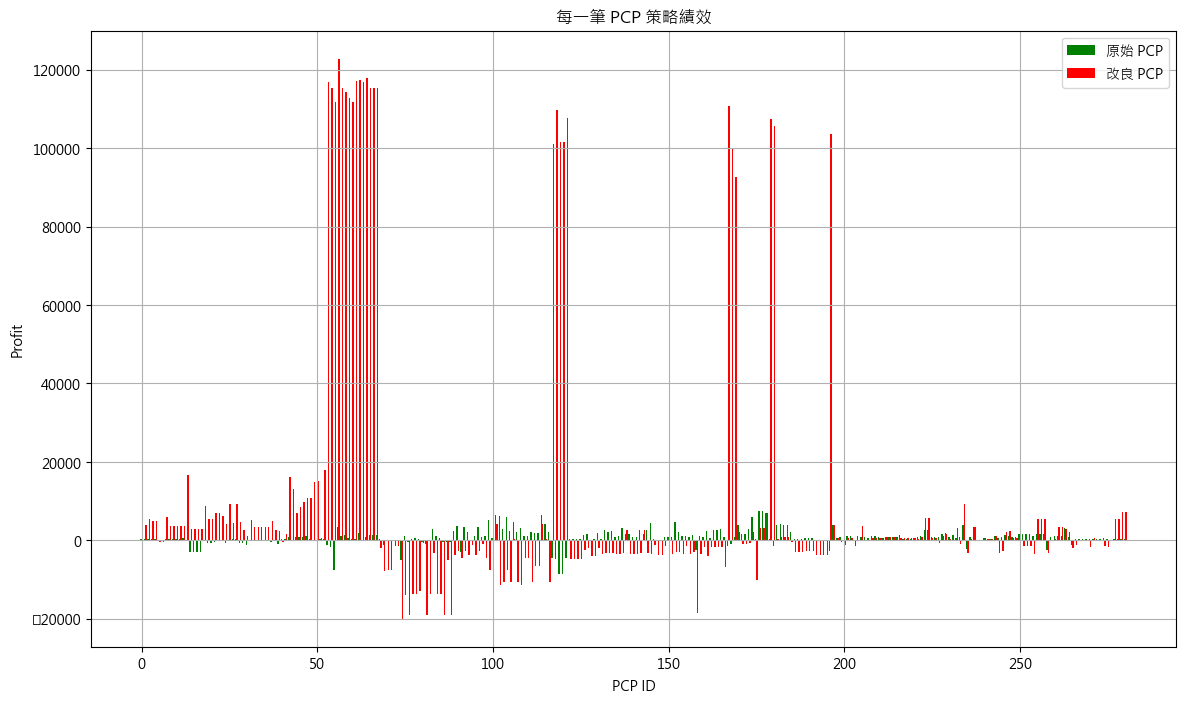

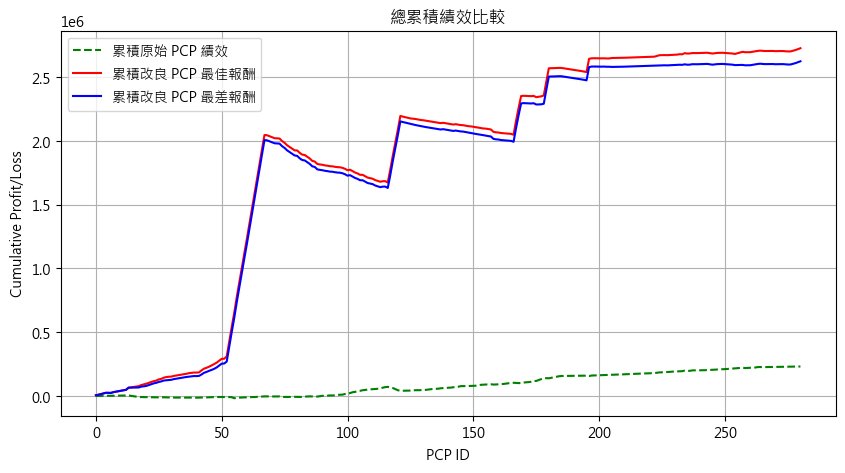

原始 PCP 最終總損益: 231490.00
改良 PCP 最終總損益(最佳情況): 2726492.29
改良 PCP 最終總損益(最差情況): 2623992.29
最佳情況獲利: 2495002.29
最差情況獲利: 2392502.29


In [314]:
def plot_pcp_performance(df_pcp_results):
    """
    視覺化 PCP 策略績效，並計算最終的總損益：
    1. 每一筆 PCP 策略的績效差異（Bar Chart）
    2. 總累積績效（Line Chart）
    3. 計算並打印最終總損益
    """

    # **提取績效數據**
    pcp_ids = df_pcp_results["PCP_ID"]
    max_profit_origin = df_pcp_results["Max Profit Origin"]
    max_profit_final = df_pcp_results["Max Profit Final"]
    max_loss_final = df_pcp_results["Max Loss Final"]

    # **計算累積績效**
    cumulative_profit_origin = np.cumsum(max_profit_origin)
    cumulative_profit_final = np.cumsum(max_profit_final.fillna(0))  # 避免 NaN
    cumulative_loss_final = np.cumsum(max_loss_final.fillna(0))  # 避免 NaN

    # **📊 每一筆 PCP 策略績效**
    plt.figure(figsize=(14, 8))
    width = 0.4  # 設定柱狀圖寬度
    plt.bar(pcp_ids - width/2, max_profit_origin, width=width, label="原始 PCP", color="green")
    plt.bar(pcp_ids + width/2, max_profit_final, width=width, label="改良 PCP", color="red")
    plt.title("每一筆 PCP 策略績效")
    plt.xlabel("PCP ID")
    plt.ylabel("Profit")
    plt.legend()
    plt.grid(True)
    plt.show()

    # **📈 總累積績效**
    plt.figure(figsize=(10, 5))
    plt.plot(pcp_ids, cumulative_profit_origin, label="累積原始 PCP 績效", linestyle="dashed", color="green")
    plt.plot(pcp_ids, cumulative_profit_final, label="累積改良 PCP 最佳報酬", linestyle="solid", color="red")
    plt.plot(pcp_ids, cumulative_loss_final, label="累積改良 PCP 最差報酬", linestyle="solid", color="blue")
    plt.title("總累積績效比較")
    plt.xlabel("PCP ID")
    plt.ylabel("Cumulative Profit/Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

    # **🔹 計算最終總損益**
    total_profit_origin = max_profit_origin.sum()
    total_profit_final = max_profit_final.sum()
    total_loss_final = max_loss_final.sum()

    print(f"原始 PCP 最終總損益: {total_profit_origin:.2f}")
    print(f"改良 PCP 最終總損益(最佳情況): {total_profit_final:.2f}")
    print(f"改良 PCP 最終總損益(最差情況): {total_loss_final:.2f}")
    print(f"最佳情況獲利: {total_profit_final - total_profit_origin:.2f}")
    print(f"最差情況獲利: {total_loss_final - total_profit_origin:.2f}")

# **使用範例**
plot_pcp_performance(df_pcp_results)


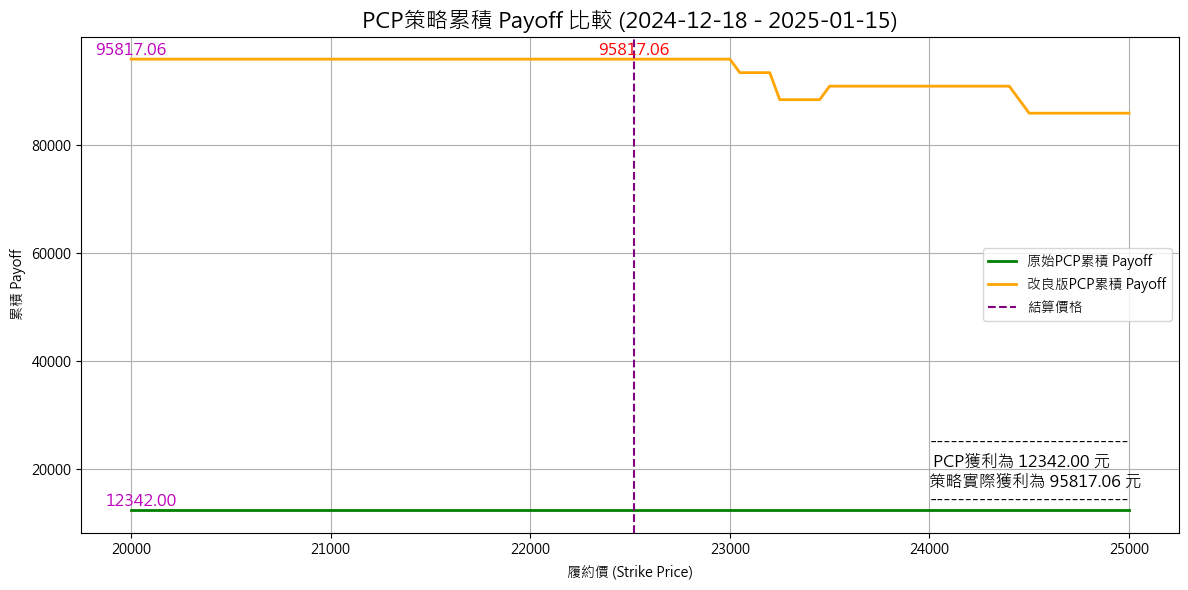

In [178]:
def plot_pcp_accumulated_payoff_by_date(df_origin, df_final, asset_low, asset_high, settlement_price, start_date, end_date):
    """
    根據日期範圍，計算並繪製原始 PCP 與改良版 PCP 累積 Payoff 曲線，
    並在圖中標示最終總獲利資訊。
    """

    # **1. 將輸入日期轉換為 datetime 格式**
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)

    # **2. 確保 DataFrame 的日期欄位是 datetime**
    df_origin['Date'] = pd.to_datetime(df_origin['Date'])
    df_final['Date'] = pd.to_datetime(df_final['Date'])

    # **3. 根據日期範圍過濾數據**
    df_origin_filtered = df_origin[(df_origin['Date'] >= start_date) & (df_origin['Date'] <= end_date)]
    df_final_filtered = df_final[(df_final['Date'] >= start_date) & (df_final['Date'] <= end_date)]

    # **4. 檢查是否有篩選到數據**
    if df_origin_filtered.empty or df_final_filtered.empty:
        print("⚠️ 篩選後的數據為空，請檢查日期範圍是否正確！")
        return

    # **5. 定義履約價範圍**
    strike_range = np.arange(asset_low, asset_high + 1, step=50)  # 使用步進值降低數據量

    # **6. 初始化累積 Payoff 曲線**
    accumulated_origin_payoff = np.zeros_like(strike_range, dtype=np.float64)
    accumulated_final_payoff = np.zeros_like(strike_range, dtype=np.float64)

    # **7. 計算原始 PCP 策略的 Payoff**
    for _, row in df_origin_filtered.iterrows():
        strike = row['StrikePrice']
        call_price = row['CallPrice']
        put_price = row['PutPrice']
        future_price = row['FuturePrice']
        fee_origin1 = row['NewFee']
        fee_settlement1 = row['SettlementFee']
        future_bs = row['FutureBS']

        # 確保數據非 NaN
        if pd.isna(strike) or pd.isna(call_price) or pd.isna(put_price) or pd.isna(future_price):
            continue

        # **計算 Payoff**
        if future_bs == 'S':  # BC + SP + SF
            payoff_origin_call = 50 * (strike_range - strike).clip(min=0) - 50*call_price
            payoff_origin_put = -50 * (strike - strike_range).clip(min=0) + 50*put_price
            payoff_origin_future = -50 * (strike_range - future_price)
        else:  # BP + SC + BF
            payoff_origin_call = -50 * (strike_range - strike).clip(min=0) + 50*call_price
            payoff_origin_put = 50 * (strike - strike_range).clip(min=0) - 50*put_price
            payoff_origin_future = 50 * (strike_range - future_price)

        payoff_origin_total = (payoff_origin_call + payoff_origin_put + payoff_origin_future) - fee_origin1 - fee_settlement1
        accumulated_origin_payoff += payoff_origin_total

    # **8. 計算改良版 PCP 策略的 Payoff**
    for _, row in df_final_filtered.iterrows():
        call_strike = row['Call_Strike']
        put_strike = row['Put_Strike']
        call_price = row['CallPrice']
        put_price = row['PutPrice']
        future_price = row['FuturePrice']
        fee_origin2 = row['NewFee']
        fee_settlement2 = row['SettlementFee']
        strategy_type = row['ArbitrageStrategy']

        # 確保數據非 NaN
        if pd.isna(call_strike) or pd.isna(put_strike) or pd.isna(call_price) or pd.isna(put_price) or pd.isna(future_price):
            continue

        # **計算改良版 Payoff**
        if strategy_type == 'SP':  # BC + SP + SF
            payoff_final_call = 50 * (strike_range - call_strike).clip(min=0) - 50*call_price
            payoff_final_put = -50 * (put_strike - strike_range).clip(min=0) + 50*put_price
            payoff_final_future = -50 * (strike_range - future_price)
        elif strategy_type == 'SC':  # BP + SC + BF
            payoff_final_put = 50 * (put_strike - strike_range).clip(min=0) - 50*put_price
            payoff_final_call = -50 * (strike_range - call_strike).clip(min=0) + 50*call_price
            payoff_final_future = 50 * (strike_range - future_price)
        else:
            print(f"❌ 未知策略: {strategy_type}")
            return None

        payoff_final_total = (payoff_final_call + payoff_final_put + payoff_final_future) - fee_origin2 - fee_settlement2
        accumulated_final_payoff += payoff_final_total

    # **9. 計算最終總損益**
    total_profit_origin = accumulated_origin_payoff.max()
    total_profit_final = accumulated_final_payoff.max()
    total_loss_final = accumulated_final_payoff.min()
    
    # **透過結算價格偵測改良版PCP的獲利**
    settlement_index = np.argmin(np.abs(strike_range - settlement_price))
    strategy_actual_profit = accumulated_final_payoff[settlement_index]

    # **10. 繪製累積 Payoff 曲線**
    fig, ax = plt.subplots(figsize=(12, 6))
    plt.plot(strike_range, accumulated_origin_payoff, label='原始PCP累積 Payoff', color='green', linewidth=2)
    plt.plot(strike_range, accumulated_final_payoff, label='改良版PCP累積 Payoff', color='orange', linewidth=2)
    plt.axvline(x=settlement_price, color='purple', linestyle='dashed', label='結算價格')
     
    # **標註最小獲利**
    min_profit_index = np.argmin(total_loss_final)
    max_profit_index = np.argmax(accumulated_final_payoff)
    max_profit_value = accumulated_final_payoff[max_profit_index]
    plt.text(strike_range[min_profit_index] , accumulated_final_payoff[min_profit_index], f'{accumulated_final_payoff[min_profit_index]:.2f}', fontsize=12, ha='center', va='bottom', color='m')
    #plt.text(strike_range[max_profit_index] , max_profit_value, f' {max_profit_value:.2f}', fontsize=12, ha='center', va='bottom', color='blue')

    # **標註策略實際獲利**
    plt.text(settlement_price , accumulated_final_payoff[settlement_index] + 100, f'{accumulated_final_payoff[settlement_index]:.2f}', fontsize=12, ha='center', va='bottom', color='red')

    # **標註PCP獲利（圖片左側）**
    plt.text(asset_low + 50, min(accumulated_origin_payoff), f'{min(accumulated_origin_payoff):.2f}', fontsize=12, ha='center', va='bottom', color='m')

    # **標註PCP與策略的最終獲利**
    plt.text(asset_high - 1000, total_profit_origin   , f'----------------------------\n PCP獲利為 {total_profit_origin:.2f} 元\n策略實際獲利為 {strategy_actual_profit:.2f} 元\n----------------------------', fontsize=12, ha='left', va='bottom', color='black')

    # **設定標題與標籤**
    plt.title(f'PCP策略累積 Payoff 比較 ({start_date.date()} - {end_date.date()})', fontsize=16)
    plt.xlabel('履約價 (Strike Price)')
    plt.ylabel('累積 Payoff')
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.0f}"))  # 確保負號能正常顯示
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_pcp_accumulated_payoff_by_date(
    df_origin=df_origin_pcp2,
    df_final=df_final_pcp2,
    asset_low=20000,
    asset_high=25000,
    settlement_price=22519,
    start_date='2024-12-18',  # 起始日期
    end_date='2025-01-15'     # 結束日期
)



In [315]:
def plot_pcp_accumulated_payoff_by_date(df_origin, df_final, asset_low, asset_high, settlement_price, start_date, end_date):
    """
    根據日期範圍，計算並繪製原始 PCP 與改良版 PCP 累積 Payoff 曲線，
    並在圖中標示最終總獲利資訊及最低 Payoff 數值。
    """

    # **1. 將輸入日期轉換為 datetime 格式**
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)

    # **2. 確保 DataFrame 的日期欄位是 datetime**
    df_origin['Date'] = pd.to_datetime(df_origin['Date'])
    df_final['Date'] = pd.to_datetime(df_final['Date'])

    # **3. 根據日期範圍過濾數據**
    df_origin_filtered = df_origin[(df_origin['Date'] >= start_date) & (df_origin['Date'] <= end_date)]
    df_final_filtered = df_final[(df_final['Date'] >= start_date) & (df_final['Date'] <= end_date)]

    # **4. 檢查是否有篩選到數據**
    if df_origin_filtered.empty or df_final_filtered.empty:
        print("⚠️ 篩選後的數據為空，請檢查日期範圍是否正確！")
        return

    # **5. 定義履約價範圍**
    strike_range = np.arange(asset_low, asset_high + 1, step=50)  # 使用步進值降低數據量

    # **6. 初始化累積 Payoff 曲線**
    accumulated_origin_payoff = np.zeros_like(strike_range, dtype=np.float64)
    accumulated_final_payoff = np.zeros_like(strike_range, dtype=np.float64)

    # **7. 計算原始 PCP 策略的 Payoff**
    for _, row in df_origin_filtered.iterrows():
        strike = row['StrikePrice']
        call_price = row['CallPrice']
        put_price = row['PutPrice']
        future_price = row['FuturePrice']
        fee_origin1 = row['NewFee']
        fee_settlement1 = row['SettlementFee']
        future_bs = row['FutureBS']

        # 確保數據非 NaN
        if pd.isna(strike) or pd.isna(call_price) or pd.isna(put_price) or pd.isna(future_price):
            continue

        # **計算 Payoff**
        if future_bs == 'S':  # BC + SP + SF
            payoff_origin_call = 50 * (strike_range - strike).clip(min=0) - 50*call_price
            payoff_origin_put = -50 * (strike - strike_range).clip(min=0) + 50*put_price
            payoff_origin_future = -50 * (strike_range - future_price)
        else:  # BP + SC + BF
            payoff_origin_call = -50 * (strike_range - strike).clip(min=0) + 50*call_price
            payoff_origin_put = 50 * (strike - strike_range).clip(min=0) - 50*put_price
            payoff_origin_future = 50 * (strike_range - future_price)

        payoff_origin_total = (payoff_origin_call + payoff_origin_put + payoff_origin_future) - fee_origin1 - fee_settlement1
        accumulated_origin_payoff += payoff_origin_total

    # **8. 計算改良版 PCP 策略的 Payoff**
    for _, row in df_final_filtered.iterrows():
        call_strike = row['Call_Strike']
        put_strike = row['Put_Strike']
        call_price = row['CallPrice']
        put_price = row['PutPrice']
        future_price = row['FuturePrice']
        fee_origin2 = row['NewFee']
        fee_settlement2 = row['SettlementFee']
        strategy_type = row['ArbitrageStrategy']

        # 確保數據非 NaN
        if pd.isna(call_strike) or pd.isna(put_strike) or pd.isna(call_price) or pd.isna(put_price) or pd.isna(future_price):
            continue

        # **計算改良版 Payoff**
        if strategy_type == 'SP':  # BC + SP + SF
            payoff_final_call = 50 * (strike_range - call_strike).clip(min=0) - 50*call_price
            payoff_final_put = -50 * (put_strike - strike_range).clip(min=0) + 50*put_price
            payoff_final_future = -50 * (strike_range - future_price)
        elif strategy_type == 'SC':  # BP + SC + BF
            payoff_final_put = 50 * (put_strike - strike_range).clip(min=0) - 50*put_price
            payoff_final_call = -50 * (strike_range - call_strike).clip(min=0) + 50*call_price
            payoff_final_future = 50 * (strike_range - future_price)
        else:
            print(f"❌ 未知策略: {strategy_type}")
            return None

        payoff_final_total = (payoff_final_call + payoff_final_put + payoff_final_future) - fee_origin2 - fee_settlement2
        accumulated_final_payoff += payoff_final_total

    # **9. 計算最終總損益**
    total_profit_origin = accumulated_origin_payoff.max()
    total_profit_final = accumulated_final_payoff.max()
    total_loss_final = accumulated_final_payoff.min()
    
    # **透過結算價格偵測改良版PCP的獲利**
    settlement_index = np.argmin(np.abs(strike_range - settlement_price))
    strategy_actual_profit = accumulated_final_payoff[settlement_index]

    # **10. 繪製累積 Payoff 曲線**
    fig, ax = plt.subplots(figsize=(12, 6))
    plt.plot(strike_range, accumulated_origin_payoff, label='原始PCP累積 Payoff', color='green', linewidth=2)
    plt.plot(strike_range, accumulated_final_payoff, label='改良版PCP累積 Payoff', color='orange', linewidth=2)
    plt.axvline(x=settlement_price, color='purple', linestyle='dashed', label='結算價格')
    
    # **標註最低 Payoff**
    min_profit_index = np.argmin(accumulated_final_payoff)
    min_profit_value = accumulated_final_payoff[min_profit_index]
    max_profit_index = np.argmax(accumulated_final_payoff)
    max_profit_value = accumulated_final_payoff[max_profit_index]
    plt.text(strike_range[min_profit_index], min_profit_value, f'{min_profit_value:.2f}', fontsize=12, ha='center', va='bottom', color='blue')
    plt.text(strike_range[max_profit_index]  , max_profit_value, f' {max_profit_value:.2f}', fontsize=12, ha='center', va='bottom', color='blue')

    # **標註策略實際獲利**
    plt.text(settlement_price, accumulated_final_payoff[settlement_index] + 100, f'{strategy_actual_profit:.2f}', fontsize=12, ha='center', va='bottom', color='red')
    
     # **標註PCP獲利（圖片左側）**
    plt.text(asset_low + 50, min(accumulated_origin_payoff), f'{min(accumulated_origin_payoff):.2f}', fontsize=12, ha='center', va='bottom', color='m')
    # **標註PCP獲利**
    plt.text(asset_high - 500, total_profit_origin, f'PCP獲利: {total_profit_origin:.2f} 元\n策略實際獲利: {strategy_actual_profit:.2f} 元', fontsize=12, ha='left', va='bottom', color='black')

    # **設定標題與標籤**
    plt.title(f'PCP策略累積 Payoff 比較 ({start_date.date()} - {end_date.date()})', fontsize=16)
    plt.xlabel('履約價 (Strike Price)')
    plt.ylabel('累積 Payoff')
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.0f}"))  # 確保負號能正常顯示
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


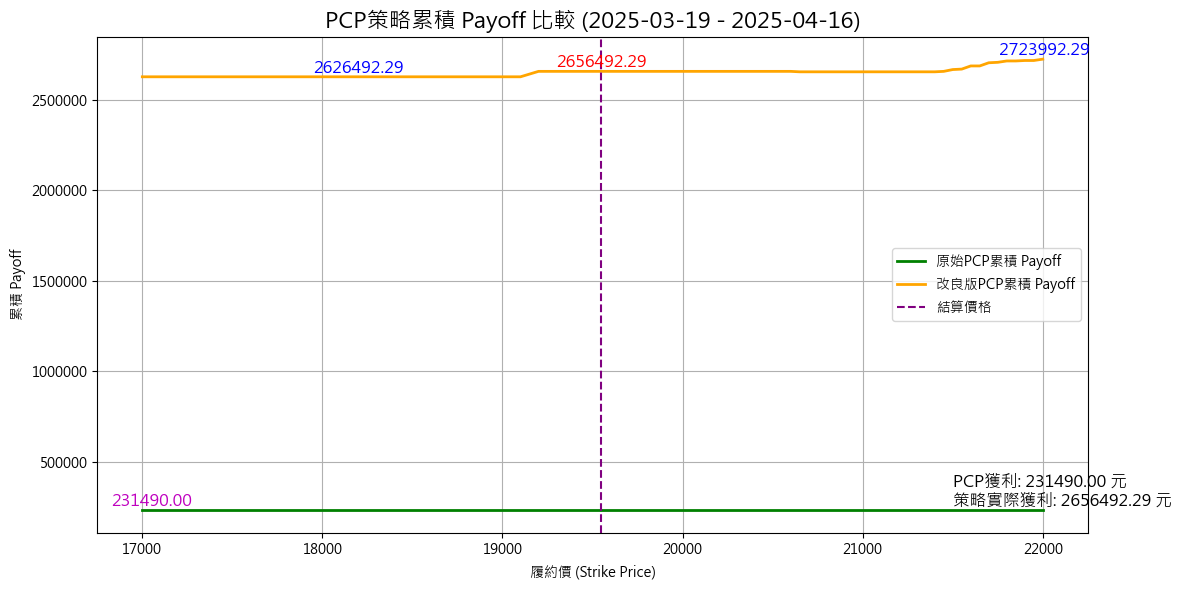

In [316]:
plot_pcp_accumulated_payoff_by_date(
    df_origin=df_origin_pcp2,
    df_final=df_final_pcp2,
    asset_low=17000,
    asset_high=22000,
    settlement_price=19548,
    start_date='2025-03-19',  # 起始日期
    end_date='2025-04-16'     # 結束日期
)